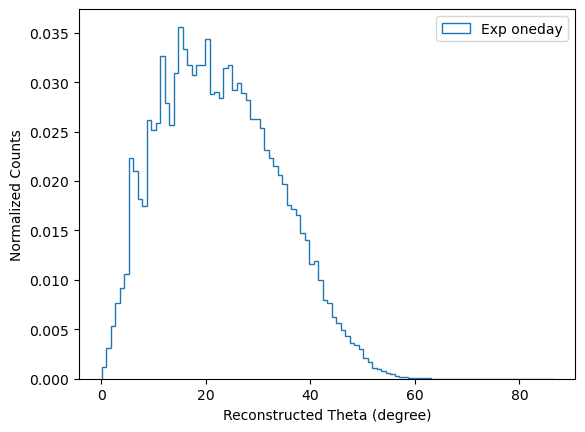

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


npz_file="/home/zhonghua/data/Dataset_Filted/Experiment/Rue1less_minus2/2024_1e10_V04_Rue1less_minus2_dataset_fastcode.csv"
exp_oneday_df=pd.read_csv(npz_file)
plt.hist(exp_oneday_df['rec_theta']*180/np.pi,bins=100,histtype='step',label='Exp oneday',density=True)
plt.xlabel('Reconstructed Theta (degree)')
plt.ylabel('Normalized Counts')
# plt.yscale('log')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import os
# /home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Proton_addweight_rho_2.5e13_5.0e17_V3.root
r_low=260
r_high=480
theta_low=0
theta_high=40 / 180.0 * np.pi
# Rmean_low=25
# Rmean_high=45.0
Eage_low=0.8
Eage_high=1.2
R_ue_high=-5.0
log10TeV_low=1.8629710674285889
log10TeV_high=2.2981839179992676

def load_allweight_model():
    def open_file(file_name):
        with uproot.open(file_name) as file:
            tree = file["Rec"]
            branches_to_read = ["E", "theta","phi","corex","corey","rec_x","rec_y","rec_theta","rec_phi","rec_Eage","Redge","NpE3","NuM1","NuM2","NuM3","NuW3","weightGaisser","weightHorandol"]
            df = tree.arrays(branches_to_read, library="pd")
            all_weights_gaisser = df['weightGaisser'].sum()
            all_weights_horandel = df['weightHorandol'].sum()
            print(file_name)
            print("     Entries:", tree.num_entries)
            print("     Total weights Gaisser:", all_weights_gaisser)
            print("     Total weights Horandel:", all_weights_horandel)

            rec_Eage=df['rec_Eage'].values
            rec_theta=df['rec_theta'].values
            NuW3=df['NuW3'].values
            rec_x=df['rec_x'].values
            rec_y=df['rec_y'].values
            r=np.sqrt(rec_x**2+rec_y**2)
            df['rec_r']=r
            cuts_indices = (rec_Eage > Eage_low) & (rec_Eage < Eage_high) & \
                            (r > r_low) & (r < r_high) & \
                            (rec_theta > theta_low) & (rec_theta < theta_high) & \
                            (NuW3 > 0)
            df_cut = df[cuts_indices].copy() 
            
            df_cut["R_ue"]=np.log10((1e-4+df_cut["NuM2"])/(df_cut["NpE3"]+1))
            print(f"     Entries after cut: {df_cut.shape[0]}")
            del df
            return df_cut
        

    def energy_correction(df: pd.DataFrame):
        theta=df["rec_theta"].values
        # df["NuW3"]  theta 作为输入
        log10_NuW3 = np.log10(df["NuW3"].values)
        feature_data = np.column_stack((log10_NuW3, theta))
        corrected_energy = model.predict(feature_data)
        df["recE"]=corrected_energy  # log10(TeV)
        # 筛选
        df_new=df[(df["recE"]>log10TeV_low) & (df["recE"]<log10TeV_high)]
        print(f" cut weight Gaisser sum: {df_new['weightGaisser'].sum()}")
        print(f" cut weight Horandel sum: {df_new['weightHorandol'].sum()}")
        del df
        return df_new


    from xgboost import XGBRegressor
    model = XGBRegressor()
    model.load_model("/home/zhonghua/Filt_Event/recE/models/energy_correction_xgb_NuW3_8-12_higher.json")
    proton_df_QF = open_file("/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Proton_addweight_rho_2.5e13_5.0e17_V3.root")
    proton_df_QF=energy_correction(proton_df_QF)

    QF_allweights_gaisser=proton_df_QF['weightGaisser'].sum()
    QF_allweights_horandel=proton_df_QF['weightHorandol'].sum()

    return QF_allweights_gaisser,QF_allweights_horandel


/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Proton_addweight_rho_2.5e13_5.0e17_V3.root
     Entries: 14217778
     Total weights Gaisser: 189.58057618423743
     Total weights Horandel: 161.1763523137651
     Entries after cut: 2426766
 cut weight Gaisser sum: 2.1193161411048975
 cut weight Horandel sum: 1.702237066429619


In [142]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def give_sig_weights(monopole_df):
    file = uproot.open("/home/zhonghua/data/exposure_Gaisser.root")
    h1 = file["h1"]
    h2 = file["h2"]
    # 获取直方图的所有数据
    values = h1.values()        # bin内容（纵坐标）
    h2_values = h2.values()        # bin内容（纵坐标）
    edges = h1.axis().edges()   # bin边界（横坐标）
    h2_edges = h2.axis().edges()   # bin边界（横坐标）
    centers = h1.axis().centers()  # bin中心
    h2_centers = h2.axis().centers()  # bin中心

    values = np.array(h1.values())
    edges = np.array(h1.axis().edges())
    centers = np.array(h1.axis().centers())
    S=np.pi * 1000**2
    parker=1e-15 * 1e4 
    nums=[]
    for i, theta in enumerate(centers):
        cosine_theta = np.cos(np.deg2rad(theta))
        area = S * cosine_theta
        exposure = values[i] * area
        num_i = exposure * parker
        nums.append(num_i)

    weights=[num_i/251000/h2_values[i]/86400 for i, num_i in enumerate(nums)]
    theta_degrees = monopole_df["theta"] * 180 / np.pi
    monopole_weights = []
    for theta in theta_degrees:
        if theta > max(centers) or theta < 0:
            weight = weights[-1] if theta > max(centers) else 0
        else:
            bin_id = np.digitize(theta, edges) - 1
            weight = weights[bin_id]
        monopole_weights.append(weight)
  
    monopole_df["weight"] = monopole_weights
    # print(f"======> Total expected monopole events after weighting: {monopole_df['weight'].sum()} ======")
    return monopole_df

def give_bkg_mc_weights_gaisser(pr_df: pd.DataFrame):
    rootfile = "/home/zhonghua/data/exposure_Gaisser.root"
    with uproot.open(rootfile) as f:
        hWeight = f["hWeight"]
        edges_E = hWeight.axes[0].edges()  # Energy bin edges
        edges_Zen = hWeight.axes[1].edges()  # Zenith bin edges
        weights_2d = hWeight.values()

    def add_weights(trueE, rec_zenith, weights_2d):
        trueE=np.log10(trueE/1e3)
        rec_zenith=180/np.pi*rec_zenith
        bin_idx_E = np.digitize(trueE, edges_E) - 1
        bin_idx_Zen = np.digitize(rec_zenith, edges_Zen) - 1
        if bin_idx_E >= weights_2d.shape[0]:
            bin_idx_E = weights_2d.shape[0] - 1
        if bin_idx_Zen >= weights_2d.shape[1]:
            bin_idx_Zen = weights_2d.shape[1] - 1
        return weights_2d[bin_idx_E, bin_idx_Zen]
    
    pr_df['gaisser_weight']=pr_df.apply(lambda row: add_weights(row['trueE'],row['rec_theta'],weights_2d),axis=1)
    pr_df['gaisser_weight']=pr_df['gaisser_weight']/86400
    # print(f"======> Total expected background MC events after weighting: {pr_df['gaisser_weight'].sum()} ======")
    return pr_df

def give_bkg_mc_weights_horandel(pr_df: pd.DataFrame):
    rootfile = "/home/zhonghua/data/exposure_Horandel.root"
    with uproot.open(rootfile) as f:
        hWeight = f["hWeight"]
        edges_E = hWeight.axes[0].edges()  # Energy bin edges
        edges_Zen = hWeight.axes[1].edges()  # Zenith bin edges
        weights_2d = hWeight.values()

    def add_weights(trueE, rec_zenith, weights_2d):
        trueE=np.log10(trueE/1e3)
        rec_zenith=180/np.pi*rec_zenith
        bin_idx_E = np.digitize(trueE, edges_E) - 1
        bin_idx_Zen = np.digitize(rec_zenith, edges_Zen) - 1
        if bin_idx_E >= weights_2d.shape[0]:
            bin_idx_E = weights_2d.shape[0] - 1
        if bin_idx_Zen >= weights_2d.shape[1]:
            bin_idx_Zen = weights_2d.shape[1] - 1
        return weights_2d[bin_idx_E, bin_idx_Zen]
    
    pr_df['horandel_weight']=pr_df.apply(lambda row: add_weights(row['trueE'],row['rec_theta'],weights_2d),axis=1)
    pr_df['horandel_weight']=pr_df['horandel_weight']/86400
    # print(f"======> Total expected background MC events after weighting: {pr_df['horandel_weight'].sum()} ======")
    return pr_df

def give_exp_weights(exp_df, Ndays):
    exp_df['weight'] = np.ones(len(exp_df)) / Ndays / 86400
    # print(f"======> Total expected exposure events after weighting: {exp_df['weight'].sum()} ======")
    return exp_df

r_low=260
r_high=480
theta_low=0
theta_high=40 / 180.0 * np.pi

Rmean_low=25
Rmean_high=45
Eage_low=0.8
Eage_high=1.15
R_ue_high=-5.0
log10TeV_low=1.8629710674285889
log10TeV_high=2.2981839179992676

def load_allweight_model():
    def open_file(file_name):
        with uproot.open(file_name) as file:
            tree = file["Rec"]
            branches_to_read = ["E", "theta","phi","corex","corey","rec_x","rec_y","rec_theta","rec_phi","rec_Eage","Redge","NpE3","NuM1","NuM2","NuM3","NuW3","weightGaisser","weightHorandol"]
            df = tree.arrays(branches_to_read, library="pd")
            all_weights_gaisser = df['weightGaisser'].sum()
            all_weights_horandel = df['weightHorandol'].sum()
            print(file_name)
            print("     Entries:", tree.num_entries)
            print("     Total weights Gaisser:", all_weights_gaisser)
            print("     Total weights Horandel:", all_weights_horandel)

            rec_Eage=df['rec_Eage'].values
            rec_theta=df['rec_theta'].values
            NuW3=df['NuW3'].values
            rec_x=df['rec_x'].values
            rec_y=df['rec_y'].values
            r=np.sqrt(rec_x**2+rec_y**2)
            df['rec_r']=r
            cuts_indices = (rec_Eage > Eage_low) & (rec_Eage < Eage_high) & \
                            (r > r_low) & (r < r_high) & \
                            (rec_theta > theta_low) & (rec_theta < theta_high) & \
                            (NuW3 > 0)
            df_cut = df[cuts_indices].copy() 
            
            df_cut["R_ue"]=np.log10((1e-4+df_cut["NuM2"])/(df_cut["NpE3"]+1))
            print(f"     Entries after cut: {df_cut.shape[0]}")
            del df
            return df_cut
        

    def energy_correction(df: pd.DataFrame):
        theta=df["rec_theta"].values
        # df["NuW3"]  theta 作为输入
        log10_NuW3 = np.log10(df["NuW3"].values)
        feature_data = np.column_stack((log10_NuW3, theta))
        corrected_energy = model.predict(feature_data)
        df["recE"]=corrected_energy  # log10(TeV)
        # 筛选
        df_new=df[(df["recE"]>log10TeV_low) & (df["recE"]<log10TeV_high)]
        print(f" cut weight Gaisser sum: {df_new['weightGaisser'].sum()}")
        print(f" cut weight Horandel sum: {df_new['weightHorandol'].sum()}")
        del df
        return df_new


    from xgboost import XGBRegressor
    model = XGBRegressor()
    model.load_model("/home/zhonghua/Filt_Event/recE/models/energy_correction_xgb_NuW3_8-12_higher.json")
    proton_df_QF = open_file("/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Proton_addweight_rho_2.5e13_5.0e17_V3.root")
    proton_df_QF=energy_correction(proton_df_QF)

    QF_allweights_gaisser=proton_df_QF['weightGaisser'].sum()
    QF_allweights_horandel=proton_df_QF['weightHorandol'].sum()

    return QF_allweights_gaisser,QF_allweights_horandel

QF_allweights_gaisser, QF_allweights_horandel = load_allweight_model()

def filter_dataset_optimized(npz_file, output_file=None, mc=True, R_mean_cut=True, is_csv=False, radius_cut=True):
    print("--------------------------------------------------")
    # param_names=["label","gaisser_weight",
    #                 "R_ue", "R_mean", "Eage",
    #                 "recE", "rec_x", "rec_y", "rec_theta", "rec_phi", 
    #                 "trueE", "NuW2", "NpE3", "NuM1", "core_x","core_y","theta"]
    if radius_cut is False:
        dr_low=0
        theta_low=0
        theta_high=70 / 180.0 * np.pi
    else:
        r_low=260
        r_high=480  
        theta_low=0
        theta_high=40 / 180.0 * np.pi

    if not is_csv:
        data = np.load(npz_file, allow_pickle=True)
        params_df = pd.DataFrame(data["params"], columns=data["param_names"])
    else:
        params_df = pd.read_csv(npz_file)
    initial_count = len(params_df)
    current_mask = np.ones(initial_count, dtype=bool)
    
    # asarray re ensure float dtype for calculations
    recE = np.asarray(params_df["recE"].values, dtype=float)
    R_ue = np.asarray(params_df["R_ue"].values, dtype=float)
    R_mean = np.asarray(params_df["R_mean"].values, dtype=float)
    Eage = np.asarray(params_df["Eage"].values, dtype=float)
    rec_theta = np.asarray(params_df["rec_theta"].values, dtype=float)
    rec_phi = np.asarray(params_df["rec_phi"].values, dtype=float)
    rec_x = np.asarray(params_df["rec_x"].values, dtype=float)
    rec_y = np.asarray(params_df["rec_y"].values, dtype=float)
    r = np.sqrt(rec_x**2 + rec_y**2)    
    dr = np.asarray(params_df["dr"].values, dtype=float)
    # -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
    # 顺序筛选与打印比例
    # -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
    print(f"--- 原始数据量: {initial_count} ---")
    

    # 1. 筛选 r (r_low < r < r_high)
    if radius_cut is False:
        r_mask = (dr > dr_low)
        # r_mask = (r > r_low) & (r < r_high)
        n_last = current_mask.sum()
        current_mask = current_mask & r_mask
        n_after = current_mask.sum()
        print(f"    1. Cut dr: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")
    elif radius_cut is True:
        r_mask = (r > r_low) & (r < r_high)
        n_last = current_mask.sum()
        current_mask = current_mask & r_mask
        n_after = current_mask.sum()
        print(f"    1. Cut r: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # 2. 筛选 theta (theta_low < theta < theta_high)
    theta_mask = (rec_theta > theta_low) & (rec_theta < theta_high)
    n_last = current_mask.sum()
    current_mask = current_mask & theta_mask
    n_after = current_mask.sum()
    print(f"    2. Cut theta: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # 0. 筛选 log10TeV (log10TeV_low < recE < log10TeV_high)
    log10TeV_mask = (recE > log10TeV_low) & (recE < log10TeV_high)
    n_last = current_mask.sum()
    current_mask = current_mask & log10TeV_mask
    n_after = current_mask.sum()
    print(f"    0. Cut log10TeV: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")
    
    # 2. 筛选 Eage (Eage_low < Eage < Eage_high)
    Eage_mask = (Eage > Eage_low) & (Eage < Eage_high)
    n_last = current_mask.sum()
    current_mask = current_mask & Eage_mask
    n_after = current_mask.sum()
    print(f"    3. Cut Eage: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")
    
    if R_mean_cut is True:
        # 3. 筛选 R_mean (Rmean_low < R_mean < Rmean_high)
        Rmean_mask = (R_mean > Rmean_low) & (R_mean < Rmean_high)
        n_last = current_mask.sum()
        current_mask = current_mask & Rmean_mask
        n_after = current_mask.sum()
        print(f"    4. Cut R_mean: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # if not mc:
    #     # 4. 筛选 R_ue (R_ue < R_ue_high)
    #     R_ue_mask = (R_ue < R_ue_high)
    #     n_last = current_mask.sum()
    #     current_mask = current_mask & R_ue_mask
    #     n_after = current_mask.sum()
    #     print(f"5. Cut R_ue: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
    # 数据保存 (保持与原函数一致)
    # -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
    
    # 打印最终统计信息
    final_count = current_mask.sum()
    print(f"    --- 筛选结果 ---")
    print(f"    原始数据量: {initial_count}")
    print(f"    筛选后数据量: {final_count}")
    print(f"    总通过比例: {final_count/initial_count:.2%}")
    if output_file is not None:
        filtered_data = {}
        keys = data.files
        
        for key in keys:
            if key == "param_names":
                filtered_data[key] = data[key]
            else:
                # 使用布尔掩码直接筛选数组，这是最快的方法
                filtered_data[key] = data[key][current_mask]

    
        output_file = npz_file.replace(".npz", "_cut_loose.npz")
        np.savez(output_file, **filtered_data)
        print(f"筛选后的数据已保存到: {output_file}")
    print("--------------------------------------------------")
    # 关闭文件
    if not is_csv:
        data.close()
    return params_df[current_mask].copy(), params_df


# Index(['label', 'weight', 'R_ue', 'R_mean', 'Eage', 'compactness', 'pincness',
#        'recE', 'rec_x', 'rec_y', 'rec_theta', 'rec_phi', 'NpE3', 'NuM1',
#        'NuM2', 'NuM3', 'NuM4', 'NuM5', 'trueE', 'core_x', 'core_y', 'theta',
#        'phi', 'dr', 'NuW3', 'NuW2'],
#       dtype='object')
# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
print("Monopole Data Processing...")
mn_npz_file =  "/home/zhonghua/data/Dataset_Filted/Monopole/filted_Monopole_1e10_merged_1000_70_dataset_muon_smooth.npz"
mn_df, mn_df_all = filter_dataset_optimized(mn_npz_file, mc=True)
mn_df = give_sig_weights(mn_df); mn_df_all = give_sig_weights(mn_df_all)

mn_df_large, mn_df_all_large = filter_dataset_optimized(mn_npz_file, mc=True, radius_cut=False)
mn_df_large = give_sig_weights(mn_df_large); mn_df_all_large = give_sig_weights(mn_df_all_large)

mn_df_beforeRmean = filter_dataset_optimized(mn_npz_file, mc=True, R_mean_cut=False)[0]
mn_df_beforeRmean = give_sig_weights(mn_df_beforeRmean)

# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
print("\nProton Data Processing...")
pr_npz_file = "/home/zhonghua/data/Dataset_Filted/Simulation/1e10_V04/Proton_combined_filted_1e10_V04_dataset_muon.npz"
pr_df, pr_df_all = filter_dataset_optimized(pr_npz_file, mc=True)
pr_df = give_bkg_mc_weights_gaisser(pr_df); pr_df_all = give_bkg_mc_weights_gaisser(pr_df_all)
pr_df = give_bkg_mc_weights_horandel(pr_df); pr_df_all = give_bkg_mc_weights_horandel(pr_df_all)

pr_df_large, pr_df_all_large = filter_dataset_optimized(pr_npz_file, mc=True, radius_cut=False)
pr_df_large = give_bkg_mc_weights_gaisser(pr_df_large); pr_df_all_large = give_bkg_mc_weights_gaisser(pr_df_all_large)
pr_df_large = give_bkg_mc_weights_horandel(pr_df_large); pr_df_all_large = give_bkg_mc_weights_horandel(pr_df_all_large)

pr_df_beforeRmean = filter_dataset_optimized(pr_npz_file, mc=True, R_mean_cut=False)[0]
pr_df_beforeRmean = give_bkg_mc_weights_gaisser(pr_df_beforeRmean); pr_df_beforeRmean = give_bkg_mc_weights_horandel(pr_df_beforeRmean)

# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
# EPOS_FLUKA pr
print("\nEPOS_FLUKA Proton Data Processing...")
pr_ef_npz_file = "/home/zhonghua/data/Dataset_Filted/CosmicRay/1e10_V04/filted_EF_Proton_4e13_1e15_dataset_muon.npz"
pr_ef_df,_ = filter_dataset_optimized(pr_ef_npz_file, mc=True)
pr_ef_df = give_bkg_mc_weights_gaisser(pr_ef_df); pr_ef_df = give_bkg_mc_weights_horandel(pr_ef_df)

pr_ef_df_beforeRmean = filter_dataset_optimized(pr_ef_npz_file, mc=True, R_mean_cut=False)[0]
pr_ef_df_beforeRmean = give_bkg_mc_weights_gaisser(pr_ef_df_beforeRmean); pr_ef_df_beforeRmean = give_bkg_mc_weights_horandel(pr_ef_df_beforeRmean)

# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
# QGSJETII_FLUKA pr
print("\nQGSJETII_FLUKA Proton Data Processing...")
pr_qf_npz_file = "/home/zhonghua/data/Dataset_Filted/CosmicRay/1e10_V04/filted_QF_Proton_4e13_1e15_dataset_muon.npz"
pr_qf_df,_ = filter_dataset_optimized(pr_qf_npz_file, mc=True)
pr_qf_df = give_bkg_mc_weights_gaisser(pr_qf_df); pr_qf_df = give_bkg_mc_weights_horandel(pr_qf_df)

pr_qf_df_beforeRmean = filter_dataset_optimized(pr_qf_npz_file, mc=True, R_mean_cut=False)[0]
pr_qf_df_beforeRmean = give_bkg_mc_weights_gaisser(pr_qf_df_beforeRmean); pr_qf_df_beforeRmean = give_bkg_mc_weights_horandel(pr_qf_df_beforeRmean)

# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
# EPOS QGSJETII weight rescale
pr_ef_df['gaisser_weight'] = pr_ef_df['gaisser_weight']*QF_allweights_gaisser/pr_ef_df_beforeRmean['gaisser_weight'].sum()
pr_ef_df['horandel_weight'] = pr_ef_df['horandel_weight']*QF_allweights_horandel/pr_ef_df_beforeRmean['horandel_weight'].sum()
pr_ef_df_beforeRmean['gaisser_weight']=pr_ef_df_beforeRmean['gaisser_weight']*QF_allweights_gaisser/pr_ef_df_beforeRmean['gaisser_weight'].sum()

pr_qf_df['gaisser_weight'] = pr_qf_df['gaisser_weight']*QF_allweights_gaisser/pr_qf_df_beforeRmean['gaisser_weight'].sum()
pr_qf_df['horandel_weight'] = pr_qf_df['horandel_weight']*QF_allweights_horandel/pr_qf_df_beforeRmean['horandel_weight'].sum()
pr_qf_df_beforeRmean['gaisser_weight']=pr_qf_df_beforeRmean['gaisser_weight']*QF_allweights_gaisser/pr_qf_df_beforeRmean['gaisser_weight'].sum()

# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
print("\nExperimental Muon Data Processing...")
exp_muon_npz_file = "/home/zhonghua/data/Dataset_Filted/Experiment/exp_muons/2023_0101_1e10_V04_dataset_muon.csv"
exp_muon_df, exp_muon_df_all = filter_dataset_optimized(exp_muon_npz_file, mc=False, is_csv=True)
exp_muon_df = give_exp_weights(exp_muon_df, Ndays=1); exp_muon_df_all = give_exp_weights(exp_muon_df_all, Ndays=1)

exp_muon_df_large, exp_muon_df_all_large = filter_dataset_optimized(exp_muon_npz_file, mc=False, radius_cut=False, is_csv=True)
exp_muon_df_large = give_exp_weights(exp_muon_df_large, Ndays=1); exp_muon_df_all_large = give_exp_weights(exp_muon_df_all_large, Ndays=1)

exp_muon_df_beforeRmean = filter_dataset_optimized(exp_muon_npz_file, mc=False, R_mean_cut=False, is_csv=True)[0]
exp_muon_df_beforeRmean = give_exp_weights(exp_muon_df_beforeRmean, Ndays=1)

# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
# Exp Rue2_2
print("\nExperimental Rue2_2 Data(2023 339days) Processing...")
exp_muon_Rue2_2_npz_file = "/home/zhonghua/data/Dataset_Filted/Experiment/Rue1less_minus2/2024_1e10_V04_Rue1less_minus2_dataset_fastcode.csv"
exp_muon_Rue2_2_df, exp_muon_Rue2_2_df_all = filter_dataset_optimized(exp_muon_Rue2_2_npz_file, mc=True, is_csv=True)
exp_muon_Rue2_2_df = give_exp_weights(exp_muon_Rue2_2_df, Ndays=364); exp_muon_Rue2_2_df_all = give_exp_weights(exp_muon_Rue2_2_df_all, Ndays=364)

exp_muon_Rue2_2_df_large, exp_muon_Rue2_2_df_all_large = filter_dataset_optimized(exp_muon_Rue2_2_npz_file, mc=False, radius_cut=False, is_csv=True)
exp_muon_Rue2_2_df_large = give_exp_weights(exp_muon_Rue2_2_df_large, Ndays=364); exp_muon_Rue2_2_df_all_large = give_exp_weights(exp_muon_Rue2_2_df_all_large, Ndays=364)

# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
print(f"Monopole ={mn_df['weight'].sum()}")
print(f"Proton Gaisser={pr_df['gaisser_weight'].sum()}, Horandel={pr_df['horandel_weight'].sum()}")
print(f"Proton EPOS_FLUKA Gaisser={pr_ef_df['gaisser_weight'].sum()}, Horandel={pr_ef_df['horandel_weight'].sum()}")
print(f"Proton QGSJETII_FLUKA Gaisser={pr_qf_df['gaisser_weight'].sum()}, Horandel={pr_qf_df['horandel_weight'].sum()}")
print(f"Experimental Muon ={exp_muon_df['weight'].sum()}")
print(f"Experimental Rue2_2 ={exp_muon_Rue2_2_df['weight'].sum()}")

print("\nLarge Radius Cut:")
print(f"Monopole ={mn_df_large['weight'].sum()}, one year={mn_df_large['weight'].sum()*365*86400}")
print(f"Proton Gaisser={pr_df_large['gaisser_weight'].sum()}, Horandel={pr_df_large['horandel_weight'].sum()}")
print(f"Experimental Muon ={exp_muon_df_large['weight'].sum()}")
print(f"Experimental Rue2_2 ={exp_muon_Rue2_2_df_large['weight'].sum()}, one year={exp_muon_Rue2_2_df_large['weight'].sum()*365*86400}")


/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Proton_addweight_rho_2.5e13_5.0e17_V3.root
     Entries: 14217778
     Total weights Gaisser: 189.58057618423743
     Total weights Horandel: 161.1763523137651
     Entries after cut: 1339492
 cut weight Gaisser sum: 0.9775459054225397
 cut weight Horandel sum: 0.785400185264704
Monopole Data Processing...
--------------------------------------------------
--- 原始数据量: 103866 ---
    1. Cut r: 40662 / 103866 (Left Ratio: 39.15%)
    2. Cut theta: 18743 / 40662 (Left Ratio: 46.09%)
    0. Cut log10TeV: 18107 / 18743 (Left Ratio: 96.61%)
    3. Cut Eage: 16340 / 18107 (Left Ratio: 90.24%)
    4. Cut R_mean: 15833 / 16340 (Left Ratio: 96.90%)
    --- 筛选结果 ---
    原始数据量: 103866
    筛选后数据量: 15833
    总通过比例: 15.24%
--------------------------------------------------
--------------------------------------------------
--- 原始数据量: 103866 ---
    1. Cut dr: 85261 / 103866 (Left Ratio: 82.09%)
    2. Cut theta: 85127 / 85261 (Left Ratio: 99.84%)
    0. 

53414.09999999999

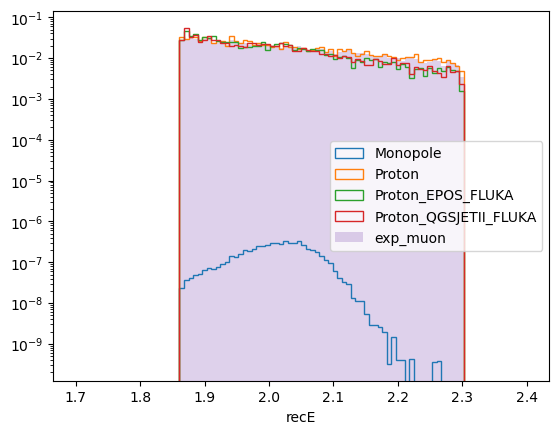

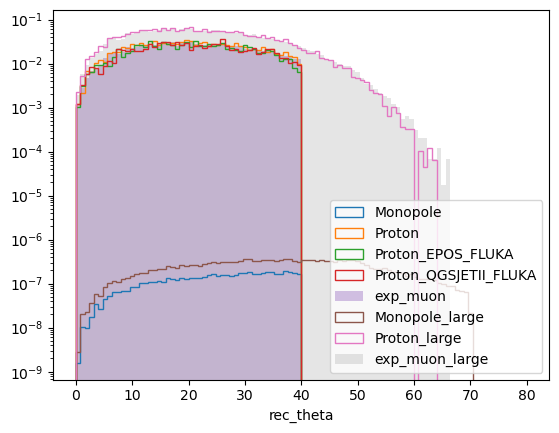

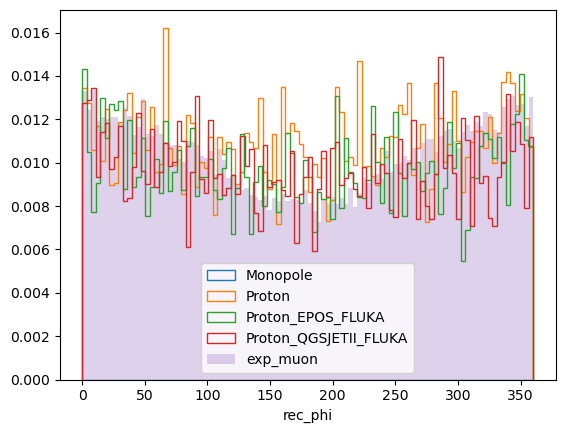

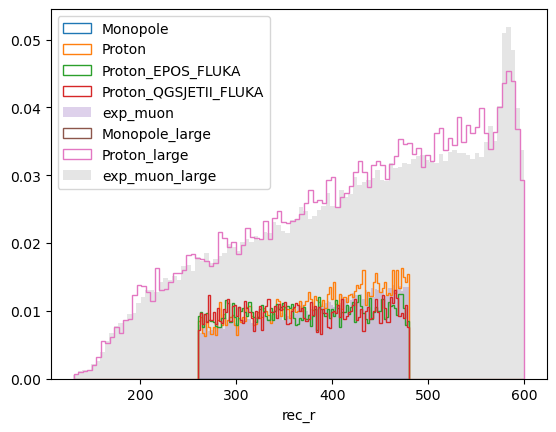

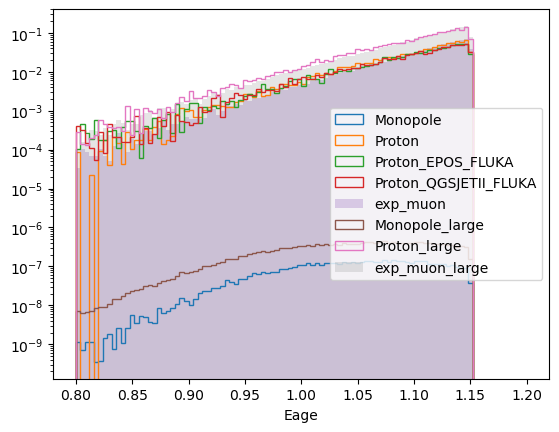

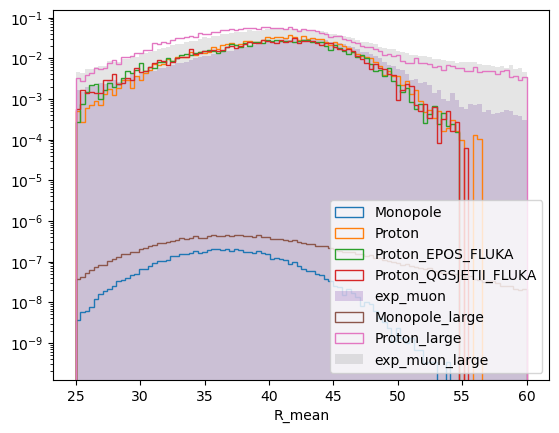

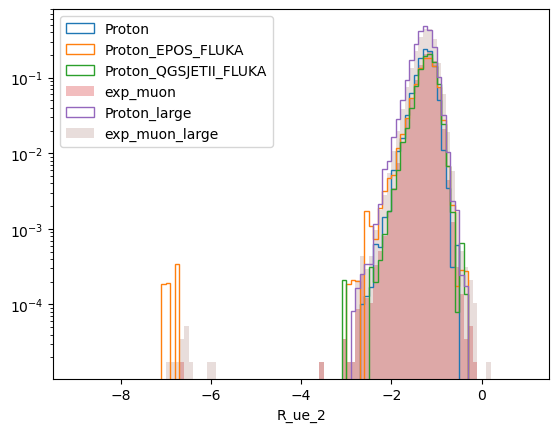

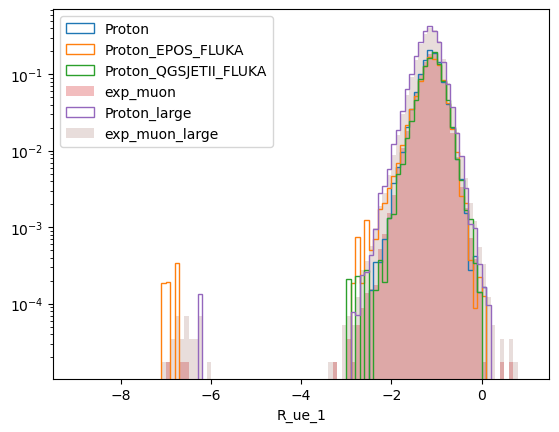

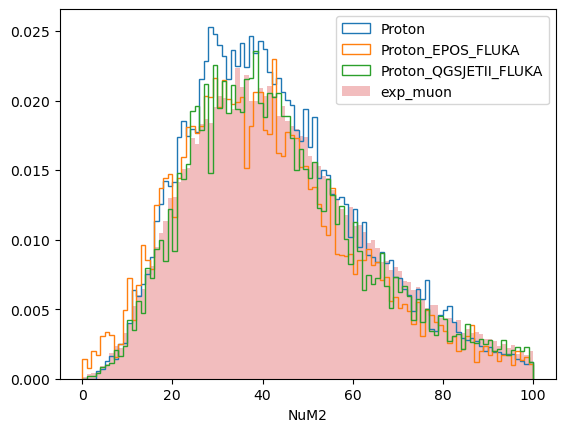

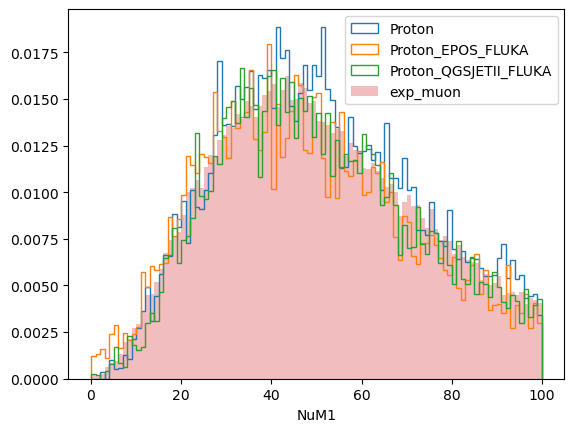

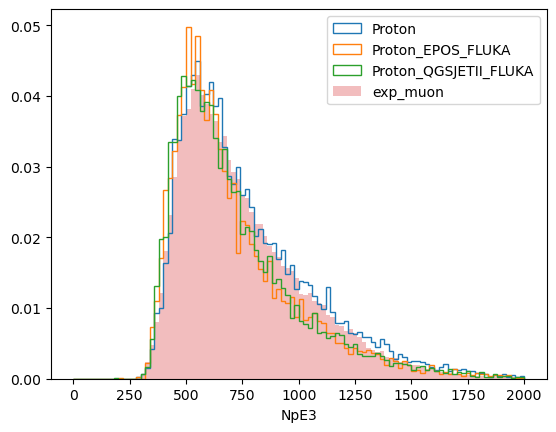

In [127]:
# recE
plt.hist(mn_df['recE'], weights=mn_df['weight'], bins=100, histtype='step', label='Monopole', range=(1.7, 2.4))
plt.hist(pr_df['recE'], weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton', range=(1.7, 2.4))
plt.hist(pr_ef_df['recE'], weights=pr_ef_df['gaisser_weight'], bins=100, histtype='step', label='Proton_EPOS_FLUKA', range=(1.7, 2.4))
plt.hist(pr_qf_df['recE'], weights=pr_qf_df['gaisser_weight'], bins=100, histtype='step', label='Proton_QGSJETII_FLUKA', range=(1.7, 2.4))
# plt.hist(mn_df_all['recE'], weights=mn_df_all['weight'], bins=100, histtype='step', label='Monopole_all', range=(1.7, 2.4))
# plt.hist(pr_df_all['recE'], weights=pr_df_all['gaisser_weight'], bins=100, histtype='step', label='Proton_all', range=(1.7, 2.4))
plt.hist(exp_muon_df['recE'], weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.3, label='exp_muon', range=(1.7, 2.4))
plt.legend()
plt.xlabel('recE')
plt.yscale('log')
plt.show()

#rec_theta
theta_range=(0,80)
plt.hist(mn_df['rec_theta']*180/np.pi, weights=mn_df['weight'], bins=100, histtype='step', label='Monopole', range=theta_range)
plt.hist(pr_df['rec_theta']*180/np.pi, weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton', range=theta_range)
plt.hist(pr_ef_df['rec_theta']*180/np.pi, weights=pr_ef_df['gaisser_weight'], bins=100, histtype='step', label='Proton_EPOS_FLUKA', range=theta_range)
plt.hist(pr_qf_df['rec_theta']*180/np.pi, weights=pr_qf_df['gaisser_weight'], bins=100, histtype='step', label='Proton_QGSJETII_FLUKA', range=theta_range)
plt.hist(exp_muon_df['rec_theta']*180/np.pi, weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.4, label='exp_muon', range=theta_range)
# plt.hist(exp_muon_Rue2_2_df['rec_theta']*180/np.pi, weights=exp_muon_Rue2_2_df['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.4, label='exp_muon_Rue2_2', range=theta_range)
# large
plt.hist(mn_df_large['rec_theta']*180/np.pi, weights=mn_df_large['weight'], bins=100, histtype='step', label='Monopole_large', range=theta_range)
plt.hist(pr_df_large['rec_theta']*180/np.pi, weights=pr_df_large['gaisser_weight'], bins=100, histtype='step', label='Proton_large', range=theta_range)
plt.hist(exp_muon_df_large['rec_theta']*180/np.pi, weights=exp_muon_df_large['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.2, label='exp_muon_large', range=theta_range)
plt.legend()
plt.xlabel('rec_theta')
plt.yscale('log')
plt.show()

# rec_phi
plt.hist(mn_df['rec_phi']*180/np.pi, weights=mn_df['weight'], bins=100, histtype='step', label='Monopole')
plt.hist(pr_df['rec_phi']*180/np.pi, weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton')
plt.hist(pr_ef_df['rec_phi']*180/np.pi, weights=pr_ef_df['gaisser_weight'], bins=100, histtype='step', label='Proton_EPOS_FLUKA')
plt.hist(pr_qf_df['rec_phi']*180/np.pi, weights=pr_qf_df['gaisser_weight'], bins=100, histtype='step', label='Proton_QGSJETII_FLUKA')
plt.hist(exp_muon_df['rec_phi']*180/np.pi, weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.3, label='exp_muon')
plt.legend()
plt.xlabel('rec_phi')
plt.show()


# rec_r
def get_rec_r(df):
    rec_x=np.asarray(df['rec_x'].values, dtype=float)
    rec_y=np.asarray(df['rec_y'].values, dtype=float)
    r=np.sqrt(rec_x**2+rec_y**2)
    return r

pr_df['rec_r']=get_rec_r(pr_df); pr_df_large['rec_r']=get_rec_r(pr_df_large)
pr_ef_df['rec_r']=get_rec_r(pr_ef_df)
pr_qf_df['rec_r']=get_rec_r(pr_qf_df)
mn_df['rec_r']=get_rec_r(mn_df); mn_df_large['rec_r']=get_rec_r(mn_df_large)
exp_muon_df['rec_r']=get_rec_r(exp_muon_df); exp_muon_df_large['rec_r']=get_rec_r(exp_muon_df_large)

plt.hist(mn_df['rec_r'], weights=mn_df['weight'], bins=100, histtype='step', label='Monopole')
plt.hist(pr_df['rec_r'], weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton')
plt.hist(pr_ef_df['rec_r'], weights=pr_ef_df['gaisser_weight'], bins=100, histtype='step', label='Proton_EPOS_FLUKA')
plt.hist(pr_qf_df['rec_r'], weights=pr_qf_df['gaisser_weight'], bins=100, histtype='step', label='Proton_QGSJETII_FLUKA')
plt.hist(exp_muon_df['rec_r'], weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.3, label='exp_muon')
# large
plt.hist(mn_df_large['rec_r'], weights=mn_df_large['weight'], bins=100, histtype='step', label='Monopole_large')
plt.hist(pr_df_large['rec_r'], weights=pr_df_large['gaisser_weight'], bins=100, histtype='step', label='Proton_large')
plt.hist(exp_muon_df_large['rec_r'], weights=exp_muon_df_large['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.2, label='exp_muon_large')
plt.legend()
plt.xlabel('rec_r')
plt.show()

# Eage
Eage_range=(0.8, 1.2)
plt.hist(mn_df['Eage'], weights=mn_df['weight'], bins=100, histtype='step', label='Monopole', range=Eage_range)
plt.hist(pr_df['Eage'], weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton', range=Eage_range)
plt.hist(pr_ef_df['Eage'], weights=pr_ef_df['gaisser_weight'], bins=100, histtype='step', label='Proton_EPOS_FLUKA', range=Eage_range)
plt.hist(pr_qf_df['Eage'], weights=pr_qf_df['gaisser_weight'], bins=100, histtype='step', label='Proton_QGSJETII_FLUKA', range=Eage_range)
# plt.hist(mn_df_beforeRmean['Eage'], weights=mn_df_beforeRmean['weight'], bins=100, histtype='step', label='Monopole_beforeRmean', range=Eage_range)
# plt.hist(pr_df_beforeRmean['Eage'], weights=pr_df_beforeRmean['gaisser_weight'], bins=100, histtype='step', label='Proton_beforeRmean', range=Eage_range)
# plt.hist(mn_df_all['Eage'], weights=mn_df_all['weight'], bins=100, histtype='step', label='Monopole_all', range=Eage_range)
# plt.hist(pr_df_all['Eage'], weights=pr_df_all['gaisser_weight'], bins=100, histtype='step', label='Proton_all', range=Eage_range)
plt.hist(exp_muon_df['Eage'], weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.3, label='exp_muon', range=Eage_range)
# plt.hist(exp_muon_df_all['Eage'], weights=exp_muon_df_all['weight'], bins=100, histtype='stepfilled',alpha=0.3, label='exp_muon_all', range=Eage_range)
# large
plt.hist(mn_df_large['Eage'], weights=mn_df_large['weight'], bins=100, histtype='step', label='Monopole_large', range=Eage_range)
plt.hist(pr_df_large['Eage'], weights=pr_df_large['gaisser_weight'], bins=100, histtype='step', label='Proton_large', range=Eage_range)
plt.hist(exp_muon_df_large['Eage'], weights=exp_muon_df_large['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.2, label='exp_muon_large', range=Eage_range)
plt.legend()
plt.xlabel('Eage')
plt.yscale('log')
plt.show()

# R_mean
Rmean_range=(25, 60)
plt.hist(mn_df['R_mean'], weights=mn_df['weight'], bins=100, histtype='step', label='Monopole', range=Rmean_range)
plt.hist(pr_df['R_mean'], weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton', range=Rmean_range)
plt.hist(pr_ef_df['R_mean'], weights=pr_ef_df['gaisser_weight'], bins=100, histtype='step', label='Proton_EPOS_FLUKA', range=Rmean_range)
plt.hist(pr_qf_df['R_mean'], weights=pr_qf_df['gaisser_weight'], bins=100, histtype='step', label='Proton_QGSJETII_FLUKA', range=Rmean_range)
# plt.hist(mn_df_all['R_mean'], weights=mn_df_all['weight'], bins=100, histtype='step', label='Monopole_all', range=Rmean_range)
# plt.hist(pr_df_all['R_mean'], weights=pr_df_all['gaisser_weight'], bins=100, histtype='step', label='Proton_all', range=Rmean_range)
plt.hist(exp_muon_df['R_mean'], weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.3, label='exp_muon', range=Rmean_range)
# plt.hist(exp_muon_df_all['R_mean'], weights=exp_muon_df_all['weight'], bins=100, histtype='stepfilled',alpha=0.3, label='exp_muon_all', range=Rmean_range)
# large
plt.hist(mn_df_large['R_mean'], weights=mn_df_large['weight'], bins=100, histtype='step', label='Monopole_large', range=Rmean_range)
plt.hist(pr_df_large['R_mean'], weights=pr_df_large['gaisser_weight'], bins=100, histtype='step', label='Proton_large', range=Rmean_range)
plt.hist(exp_muon_df_large['R_mean'], weights=exp_muon_df_large['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.2, label='exp_muon_large', range=Rmean_range)
plt.legend()
plt.xlabel('R_mean')
plt.yscale('log')
plt.show()

# R_ue

def R_ue(df):
    NuM1=np.asarray(df['NuM1'].values, dtype=float)
    NuM2=np.asarray(df['NuM2'].values, dtype=float)
    NuM3=np.asarray(df['NuM3'].values, dtype=float)
    NpE3=np.asarray(df['NpE3'].values, dtype=float)
    df['R_ue_1']= np.log10((NuM1 + 1e-4) / (NpE3))
    df['R_ue_2']= np.log10((NuM2 + 1e-4) / (NpE3))
    df['R_ue_3']= np.log10((NuM3 + 1e-4) / (NpE3))
    return df
mn_df=R_ue(mn_df); mn_df_large=R_ue(mn_df_large)
pr_df=R_ue(pr_df); pr_df_large=R_ue(pr_df_large)
pr_ef_df=R_ue(pr_ef_df)
pr_qf_df=R_ue(pr_qf_df)
exp_muon_df=R_ue(exp_muon_df); exp_muon_df_large=R_ue(exp_muon_df_large)
exp_muon_Rue2_2_df=R_ue(exp_muon_Rue2_2_df); exp_muon_Rue2_2_df_large=R_ue(exp_muon_Rue2_2_df_large)

# plt.hist(mn_df['R_ue'], weights=mn_df['weight'], bins=100, histtype='step', label='Monopole', range=(-9, 1))
plt.hist(pr_df['R_ue_2'], weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton', range=(-9, 1))
plt.hist(pr_ef_df['R_ue_2'], weights=pr_ef_df['gaisser_weight'], bins=100, histtype='step', label='Proton_EPOS_FLUKA', range=(-9, 1))
plt.hist(pr_qf_df['R_ue_2'], weights=pr_qf_df['gaisser_weight'], bins=100, histtype='step', label='Proton_QGSJETII_FLUKA', range=(-9, 1))
plt.hist(exp_muon_df['R_ue_2'], weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.3, label='exp_muon', range=(-9, 1))
# large
# plt.hist(mn_df_large['R_ue_2'], weights=mn_df_large['weight'], bins=100, histtype='step', label='Monopole_large', range=(-9, 1))
plt.hist(pr_df_large['R_ue_2'], weights=pr_df_large['gaisser_weight'], bins=100, histtype='step', label='Proton_large', range=(-9, 1))
plt.hist(exp_muon_df_large['R_ue_2'], weights=exp_muon_df_large['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.2, label='exp_muon_large', range=(-9, 1))
plt.legend()
plt.xlabel('R_ue_2')
plt.yscale('log')
plt.show()
# R_ue_1
# plt.hist(mn_df['R_ue_1'], weights=mn_df['weight'], bins=100, histtype='step', label='Monopole', range=(-9, 1))
plt.hist(pr_df['R_ue_1'], weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton', range=(-9, 1))
plt.hist(pr_ef_df['R_ue_1'], weights=pr_ef_df['gaisser_weight'], bins=100, histtype='step', label='Proton_EPOS_FLUKA', range=(-9, 1))
plt.hist(pr_qf_df['R_ue_1'], weights=pr_qf_df['gaisser_weight'], bins=100, histtype='step', label='Proton_QGSJETII_FLUKA', range=(-9, 1))
plt.hist(exp_muon_df['R_ue_1'], weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.3, label='exp_muon', range=(-9, 1))
# large
# plt.hist(mn_df_large['R_ue_1'], weights=mn_df_large['weight'], bins=100, histtype='step', label='Monopole_large', range=(-9, 1))
plt.hist(pr_df_large['R_ue_1'], weights=pr_df_large['gaisser_weight'], bins=100, histtype='step', label='Proton_large', range=(-9, 1))
plt.hist(exp_muon_df_large['R_ue_1'], weights=exp_muon_df_large['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.2, label='exp_muon_large', range=(-9, 1))
plt.legend()
plt.xlabel('R_ue_1')
plt.yscale('log')
plt.show()
# NuM2
# plt.hist(pr_df["NuM1"], weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton', range=(0, 100))
plt.hist(pr_df["NuM2"], weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton', range=(0, 100))
plt.hist(pr_ef_df["NuM2"], weights=pr_ef_df['gaisser_weight'], bins=100, histtype='step', label='Proton_EPOS_FLUKA', range=(0, 100))
plt.hist(pr_qf_df["NuM2"], weights=pr_qf_df['gaisser_weight'], bins=100, histtype='step', label='Proton_QGSJETII_FLUKA', range=(0, 100))
# plt.hist(pr_df["NuM3"], weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton', range=(0, 100))
# plt.hist(exp_muon_df["NuM1"], weights=exp_muon_df['weight']*1.5, bins=100, histtype='step',alpha=0.3, label='exp_muon', range=(0, 100))
plt.hist(exp_muon_df["NuM2"], weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.3, label='exp_muon', range=(0, 100))
# 
# plt.hist(exp_muon_df["NuM3"], weights=exp_muon_df['weight']*1.5, bins=100, histtype='step',alpha=0.3, label='exp_muon', range=(0, 100))
plt.legend()
plt.xlabel('NuM2')
# plt.yscale('log')
plt.show()
#NuM1
plt.hist(pr_df["NuM1"], weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton', range=(0, 100))
plt.hist(pr_ef_df["NuM1"], weights=pr_ef_df['gaisser_weight'], bins=100, histtype='step', label='Proton_EPOS_FLUKA', range=(0, 100))
plt.hist(pr_qf_df["NuM1"], weights=pr_qf_df['gaisser_weight'], bins=100, histtype='step', label='Proton_QGSJETII_FLUKA', range=(0, 100))
plt.hist(exp_muon_df["NuM1"], weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.3, label='exp_muon', range=(0, 100))
plt.legend()
plt.xlabel('NuM1')
# plt.yscale('log')
plt.show()
# NpE3
NpE3_range=(0, 2000)
plt.hist(pr_df["NpE3"], weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton', range=NpE3_range)
plt.hist(pr_ef_df["NpE3"], weights=pr_ef_df['gaisser_weight'], bins=100, histtype='step', label='Proton_EPOS_FLUKA', range=NpE3_range)
plt.hist(pr_qf_df["NpE3"], weights=pr_qf_df['gaisser_weight'], bins=100, histtype='step', label='Proton_QGSJETII_FLUKA', range=NpE3_range)
plt.hist(exp_muon_df["NpE3"], weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.3, label='exp_muon', range=NpE3_range)
plt.legend()
plt.xlabel('NpE3')
# plt.yscale('log')
plt.show()




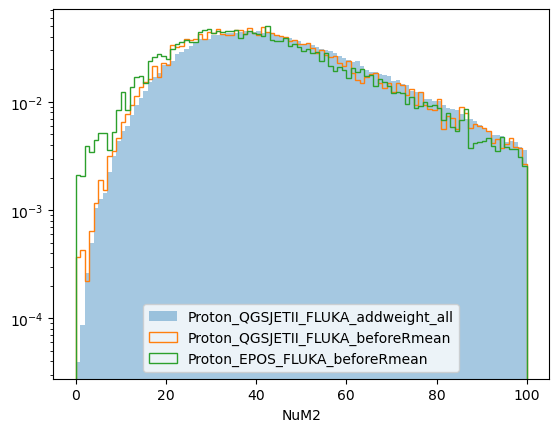

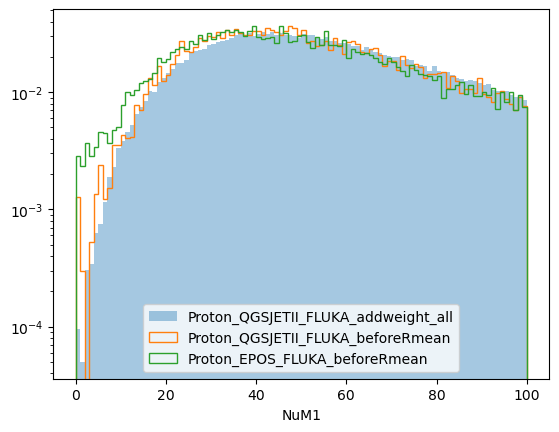

In [77]:
# NuM2
plt.hist(proton_df_QF["NuM2"], weights=proton_df_QF['weightGaisser'], bins=100, histtype='stepfilled', alpha=0.4,label='Proton_QGSJETII_FLUKA_addweight_all', range=(0, 100))
plt.hist(pr_qf_df_beforeRmean["NuM2"], weights=pr_qf_df_beforeRmean['gaisser_weight'], bins=100, histtype='step', label='Proton_QGSJETII_FLUKA_beforeRmean', range=(0, 100))
plt.hist(pr_ef_df_beforeRmean["NuM2"], weights=pr_ef_df_beforeRmean['gaisser_weight'], bins=100, histtype='step', label='Proton_EPOS_FLUKA_beforeRmean', range=(0, 100))
plt.legend()
plt.xlabel('NuM2')
plt.yscale('log')
plt.show()
# NuM1
plt.hist(proton_df_QF["NuM1"], weights=proton_df_QF['weightGaisser'], bins=100, histtype='stepfilled', alpha=0.4,label='Proton_QGSJETII_FLUKA_addweight_all', range=(0, 100))
plt.hist(pr_qf_df_beforeRmean["NuM1"], weights=pr_qf_df_beforeRmean['gaisser_weight'], bins=100, histtype='step', label='Proton_QGSJETII_FLUKA_beforeRmean', range=(0, 100))    
plt.hist(pr_ef_df_beforeRmean["NuM1"], weights=pr_ef_df_beforeRmean['gaisser_weight'], bins=100, histtype='step', label='Proton_EPOS_FLUKA_beforeRmean', range=(0, 100))    
plt.legend()
plt.xlabel('NuM1')
plt.yscale('log')
plt.show()


In [52]:
np.log10((1e-4+20)/1000)


-1.6989678328690379

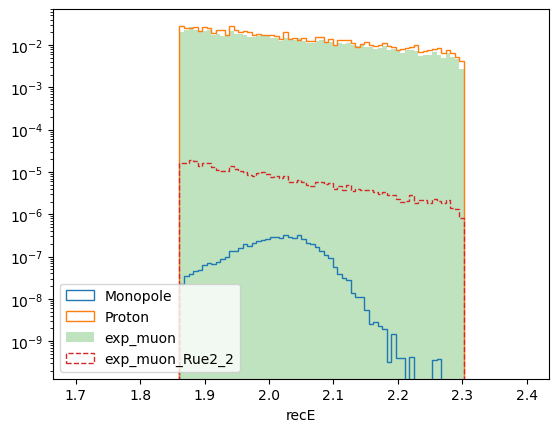

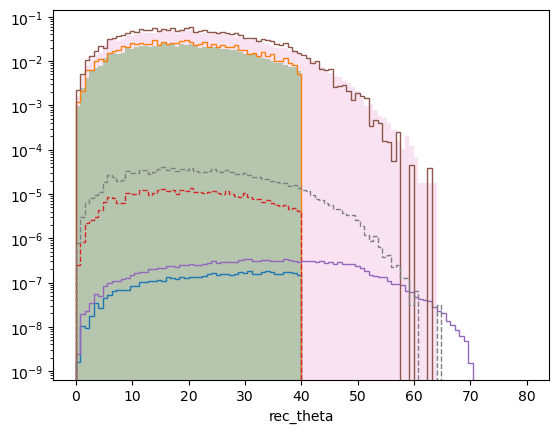

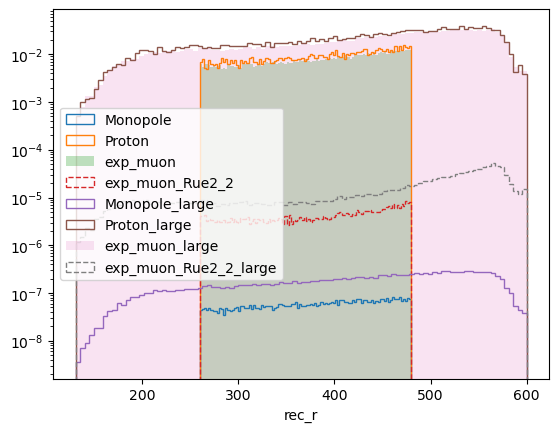

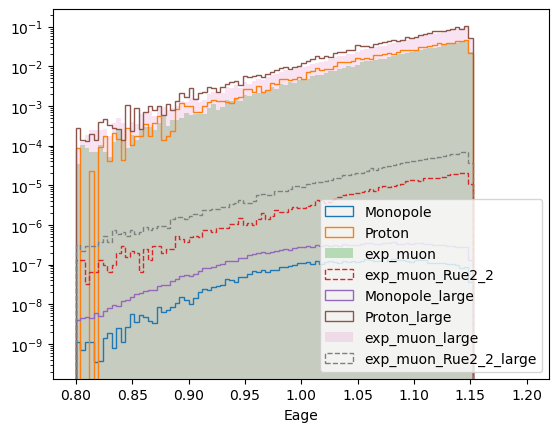

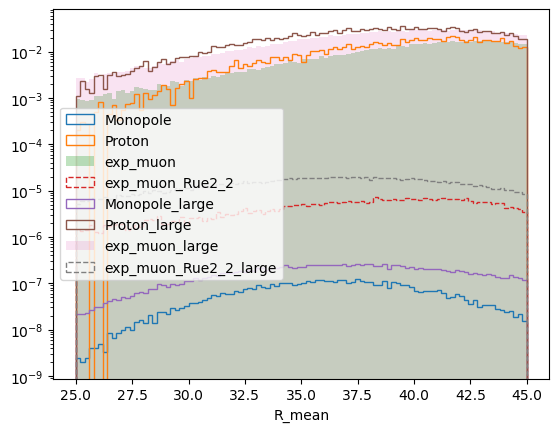

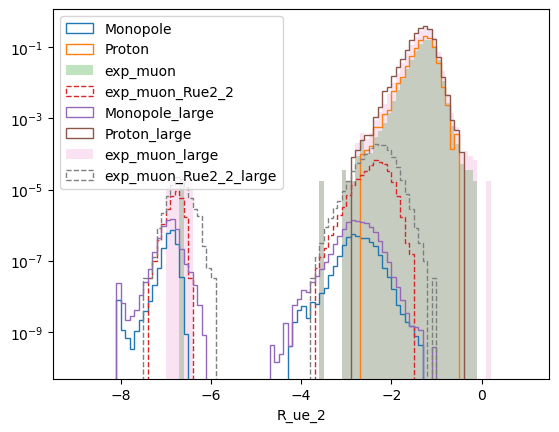

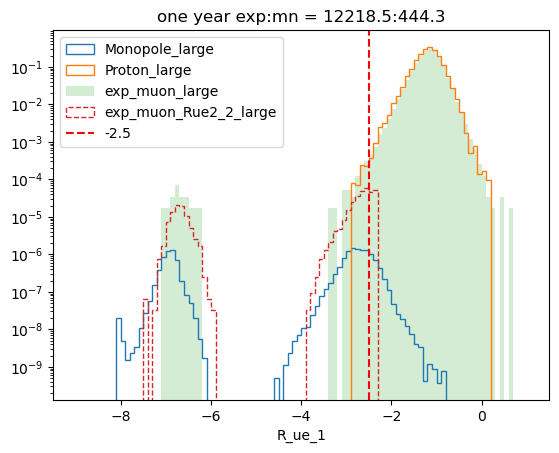

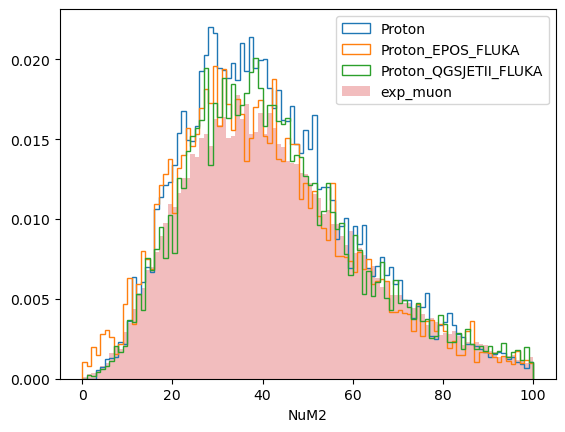

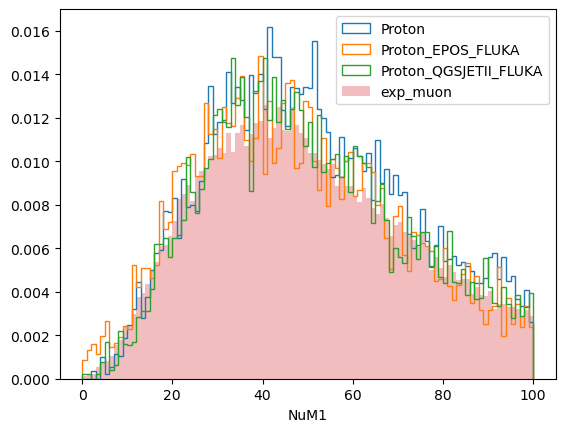

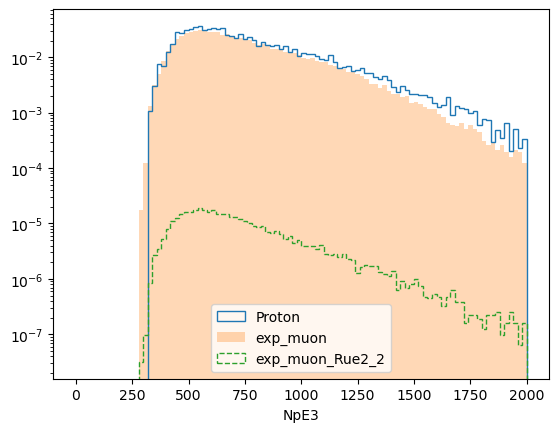

In [144]:
# recE
plt.hist(mn_df['recE'], weights=mn_df['weight'], bins=100, histtype='step', label='Monopole', range=(1.7, 2.4))
plt.hist(pr_df['recE'], weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton', range=(1.7, 2.4))
plt.hist(exp_muon_df['recE'], weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.3, label='exp_muon', range=(1.7, 2.4))
plt.hist(exp_muon_Rue2_2_df['recE'], weights=exp_muon_Rue2_2_df['weight'], bins=100, histtype='step', linestyle='dashed',  label='exp_muon_Rue2_2', range=(1.7, 2.4))
plt.legend()
plt.xlabel('recE')
plt.yscale('log')
plt.show()

#rec_theta
theta_range=(0,80)
plt.hist(mn_df['rec_theta']*180/np.pi, weights=mn_df['weight'], bins=100, histtype='step', label='Monopole', range=theta_range)
plt.hist(pr_df['rec_theta']*180/np.pi, weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton', range=theta_range)
plt.hist(exp_muon_df['rec_theta']*180/np.pi, weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.4, label='exp_muon', range=theta_range)
plt.hist(exp_muon_Rue2_2_df['rec_theta']*180/np.pi, weights=exp_muon_Rue2_2_df['weight'], bins=100, histtype='step', linestyle='dashed',  label='exp_muon_Rue2_2', range=theta_range)
# large
plt.hist(mn_df_large['rec_theta']*180/np.pi, weights=mn_df_large['weight'], bins=100, histtype='step', label='Monopole_large', range=theta_range)
plt.hist(pr_df_large['rec_theta']*180/np.pi, weights=pr_df_large['gaisser_weight'], bins=100, histtype='step', label='Proton_large', range=theta_range)
plt.hist(exp_muon_df_large['rec_theta']*180/np.pi, weights=exp_muon_df_large['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.2, label='exp_muon_large', range=theta_range)
plt.hist(exp_muon_Rue2_2_df_large['rec_theta']*180/np.pi, weights=exp_muon_Rue2_2_df_large['weight'], bins=100, histtype='step', linestyle='dashed', label='exp_muon_Rue2_2_large', range=theta_range)
# plt.legend()
plt.xlabel('rec_theta')
plt.yscale('log')
plt.show()

# # rec_phi
# plt.hist(mn_df['rec_phi']*180/np.pi, weights=mn_df['weight'], bins=100, histtype='step', label='Monopole')
# plt.hist(pr_df['rec_phi']*180/np.pi, weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton')
# plt.hist(pr_ef_df['rec_phi']*180/np.pi, weights=pr_ef_df['gaisser_weight'], bins=100, histtype='step', label='Proton_EPOS_FLUKA')
# plt.hist(pr_qf_df['rec_phi']*180/np.pi, weights=pr_qf_df['gaisser_weight'], bins=100, histtype='step', label='Proton_QGSJETII_FLUKA')
# plt.hist(exp_muon_df['rec_phi']*180/np.pi, weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.3, label='exp_muon')
# plt.legend()
# plt.xlabel('rec_phi')
# plt.show()


# rec_r
def get_rec_r(df):
    rec_x=np.asarray(df['rec_x'].values, dtype=float)
    rec_y=np.asarray(df['rec_y'].values, dtype=float)
    r=np.sqrt(rec_x**2+rec_y**2)
    return r

pr_df['rec_r']=get_rec_r(pr_df); pr_df_large['rec_r']=get_rec_r(pr_df_large)
pr_ef_df['rec_r']=get_rec_r(pr_ef_df)
pr_qf_df['rec_r']=get_rec_r(pr_qf_df)
mn_df['rec_r']=get_rec_r(mn_df); mn_df_large['rec_r']=get_rec_r(mn_df_large)
exp_muon_df['rec_r']=get_rec_r(exp_muon_df); exp_muon_df_large['rec_r']=get_rec_r(exp_muon_df_large)
exp_muon_Rue2_2_df['rec_r']=get_rec_r(exp_muon_Rue2_2_df); exp_muon_Rue2_2_df_large['rec_r']=get_rec_r(exp_muon_Rue2_2_df_large)

plt.hist(mn_df['rec_r'], weights=mn_df['weight'], bins=100, histtype='step', label='Monopole')
plt.hist(pr_df['rec_r'], weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton')
plt.hist(exp_muon_df['rec_r'], weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.3, label='exp_muon')
plt.hist(exp_muon_Rue2_2_df['rec_r'], weights=exp_muon_Rue2_2_df['weight'], bins=100, histtype='step', linestyle='dashed', label='exp_muon_Rue2_2')
# large
plt.hist(mn_df_large['rec_r'], weights=mn_df_large['weight'], bins=100, histtype='step', label='Monopole_large')
plt.hist(pr_df_large['rec_r'], weights=pr_df_large['gaisser_weight'], bins=100, histtype='step', label='Proton_large')
plt.hist(exp_muon_df_large['rec_r'], weights=exp_muon_df_large['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.2, label='exp_muon_large')
plt.hist(exp_muon_Rue2_2_df_large['rec_r'], weights=exp_muon_Rue2_2_df_large['weight'], bins=100, histtype='step', linestyle='dashed', label='exp_muon_Rue2_2_large')
plt.legend()
plt.yscale('log')
plt.xlabel('rec_r')
plt.show()

# Eage
Eage_range=(0.8, 1.2)
plt.hist(mn_df['Eage'], weights=mn_df['weight'], bins=100, histtype='step', label='Monopole', range=Eage_range)
plt.hist(pr_df['Eage'], weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton', range=Eage_range)
plt.hist(exp_muon_df['Eage'], weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.3, label='exp_muon', range=Eage_range)
plt.hist(exp_muon_Rue2_2_df['Eage'], weights=exp_muon_Rue2_2_df['weight'], bins=100, histtype='step', linestyle='dashed', label='exp_muon_Rue2_2', range=Eage_range)
# large
plt.hist(mn_df_large['Eage'], weights=mn_df_large['weight'], bins=100, histtype='step', label='Monopole_large', range=Eage_range)
plt.hist(pr_df_large['Eage'], weights=pr_df_large['gaisser_weight'], bins=100, histtype='step', label='Proton_large', range=Eage_range)
plt.hist(exp_muon_df_large['Eage'], weights=exp_muon_df_large['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.2, label='exp_muon_large', range=Eage_range)
plt.hist(exp_muon_Rue2_2_df_large['Eage'], weights=exp_muon_Rue2_2_df_large['weight'], bins=100, histtype='step', linestyle='dashed', label='exp_muon_Rue2_2_large', range=Eage_range)
plt.legend()
plt.xlabel('Eage')
plt.yscale('log')
plt.show()

# R_mean
Rmean_range=(25, 45)
plt.hist(mn_df['R_mean'], weights=mn_df['weight'], bins=100, histtype='step', label='Monopole', range=Rmean_range)
plt.hist(pr_df['R_mean'], weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton', range=Rmean_range)
plt.hist(exp_muon_df['R_mean'], weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.3, label='exp_muon', range=Rmean_range)
plt.hist(exp_muon_Rue2_2_df['R_mean'], weights=exp_muon_Rue2_2_df['weight'], bins=100, histtype='step', linestyle='dashed', label='exp_muon_Rue2_2', range=Rmean_range)
# large
plt.hist(mn_df_large['R_mean'], weights=mn_df_large['weight'], bins=100, histtype='step', label='Monopole_large', range=Rmean_range)
plt.hist(pr_df_large['R_mean'], weights=pr_df_large['gaisser_weight'], bins=100, histtype='step', label='Proton_large', range=Rmean_range)
plt.hist(exp_muon_df_large['R_mean'], weights=exp_muon_df_large['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.2, label='exp_muon_large', range=Rmean_range)
plt.hist(exp_muon_Rue2_2_df_large['R_mean'], weights=exp_muon_Rue2_2_df_large['weight'], bins=100, histtype='step', linestyle='dashed', label='exp_muon_Rue2_2_large', range=Rmean_range)
plt.legend()
plt.xlabel('R_mean')
plt.yscale('log')
plt.show()

# R_ue

def R_ue(df):
    NuM1=np.asarray(df['NuM1'].values, dtype=float)
    NuM2=np.asarray(df['NuM2'].values, dtype=float)
    NuM3=np.asarray(df['NuM3'].values, dtype=float)
    NpE3=np.asarray(df['NpE3'].values, dtype=float)
    df['R_ue_1']= np.log10((NuM1 + 1e-4) / (NpE3))
    df['R_ue_2']= np.log10((NuM2 + 1e-4) / (NpE3))
    df['R_ue_3']= np.log10((NuM3 + 1e-4) / (NpE3))
    return df
mn_df=R_ue(mn_df); mn_df_large=R_ue(mn_df_large)
pr_df=R_ue(pr_df); pr_df_large=R_ue(pr_df_large)
pr_ef_df=R_ue(pr_ef_df)
pr_qf_df=R_ue(pr_qf_df)
exp_muon_df=R_ue(exp_muon_df); exp_muon_df_large=R_ue(exp_muon_df_large)
exp_muon_Rue2_2_df=R_ue(exp_muon_Rue2_2_df); exp_muon_Rue2_2_df_large=R_ue(exp_muon_Rue2_2_df_large)

plt.hist(mn_df['R_ue'], weights=mn_df['weight'], bins=100, histtype='step', label='Monopole', range=(-9, 1))
plt.hist(pr_df['R_ue_2'], weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton', range=(-9, 1))
plt.hist(exp_muon_df['R_ue_2'], weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.3, label='exp_muon', range=(-9, 1))
plt.hist(exp_muon_Rue2_2_df['R_ue_2'], weights=exp_muon_Rue2_2_df['weight'], bins=100, histtype='step', linestyle='dashed', label='exp_muon_Rue2_2', range=(-9, 1))
# large
plt.hist(mn_df_large['R_ue'], weights=mn_df_large['weight'], bins=100, histtype='step', label='Monopole_large', range=(-9, 1))
plt.hist(pr_df_large['R_ue_2'], weights=pr_df_large['gaisser_weight'], bins=100, histtype='step', label='Proton_large', range=(-9, 1))
plt.hist(exp_muon_df_large['R_ue_2'], weights=exp_muon_df_large['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.2, label='exp_muon_large', range=(-9, 1))
plt.hist(exp_muon_Rue2_2_df_large['R_ue_2'], weights=exp_muon_Rue2_2_df_large['weight'], bins=100, histtype='step', linestyle='dashed', label='exp_muon_Rue2_2_large', range=(-9, 1))
plt.legend()
plt.xlabel('R_ue_2')
plt.yscale('log')
plt.show()
# # R_ue_1
# plt.hist(mn_df['R_ue_1'], weights=mn_df['weight'], bins=100, histtype='step', label='Monopole', range=(-9, 1))
# plt.hist(pr_df['R_ue_1'], weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton', range=(-9, 1))
# plt.hist(exp_muon_df['R_ue_1'], weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.3, label='exp_muon', range=(-9, 1))
# plt.hist(exp_muon_Rue2_2_df['R_ue_1'], weights=exp_muon_Rue2_2_df['weight'], bins=100, histtype='step', linestyle='dashed', label='exp_muon_Rue2_2', range=(-9, 1))
# large
R_ue_cut_new=-2.5
exp_muon_Rue2_2_df_large_new = exp_muon_Rue2_2_df_large[exp_muon_Rue2_2_df_large['R_ue']<R_ue_cut_new]
mn_df_large_new = mn_df_large[mn_df_large['R_ue']<R_ue_cut_new]
plt.hist(mn_df_large['R_ue_1'], weights=mn_df_large['weight'], bins=100, histtype='step', label='Monopole_large', range=(-9, 1))
plt.hist(pr_df_large['R_ue_1'], weights=pr_df_large['gaisser_weight'], bins=100, histtype='step', label='Proton_large', range=(-9, 1))
plt.hist(exp_muon_df_large['R_ue_1'], weights=exp_muon_df_large['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.2, label='exp_muon_large', range=(-9, 1))
plt.hist(exp_muon_Rue2_2_df_large_new['R_ue_1'], weights=exp_muon_Rue2_2_df_large_new['weight'], bins=100, histtype='step', linestyle='dashed', label='exp_muon_Rue2_2_large', range=(-9, 1))
plt.axvline(R_ue_cut_new, color='r', linestyle='--', label=f'{R_ue_cut_new}')
plt.legend()
plt.xlabel('R_ue_1')
plt.yscale('log')
plt.title(f"one year exp:mn = {exp_muon_Rue2_2_df_large_new['weight'].sum()*365*86400:.1f}:{mn_df_large_new['weight'].sum()*365*86400:.1f}")
plt.show()

# NuM2
# plt.hist(pr_df["NuM1"], weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton', range=(0, 100))
plt.hist(pr_df["NuM2"], weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton', range=(0, 100))
plt.hist(pr_ef_df["NuM2"], weights=pr_ef_df['gaisser_weight'], bins=100, histtype='step', label='Proton_EPOS_FLUKA', range=(0, 100))
plt.hist(pr_qf_df["NuM2"], weights=pr_qf_df['gaisser_weight'], bins=100, histtype='step', label='Proton_QGSJETII_FLUKA', range=(0, 100))
# plt.hist(pr_df["NuM3"], weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton', range=(0, 100))
# plt.hist(exp_muon_df["NuM1"], weights=exp_muon_df['weight']*1.5, bins=100, histtype='step',alpha=0.3, label='exp_muon', range=(0, 100))
plt.hist(exp_muon_df["NuM2"], weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.3, label='exp_muon', range=(0, 100))
# 
# plt.hist(exp_muon_df["NuM3"], weights=exp_muon_df['weight']*1.5, bins=100, histtype='step',alpha=0.3, label='exp_muon', range=(0, 100))
plt.legend()
plt.xlabel('NuM2')
# plt.yscale('log')
plt.show()
#NuM1
plt.hist(pr_df["NuM1"], weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton', range=(0, 100))
plt.hist(pr_ef_df["NuM1"], weights=pr_ef_df['gaisser_weight'], bins=100, histtype='step', label='Proton_EPOS_FLUKA', range=(0, 100))
plt.hist(pr_qf_df["NuM1"], weights=pr_qf_df['gaisser_weight'], bins=100, histtype='step', label='Proton_QGSJETII_FLUKA', range=(0, 100))
plt.hist(exp_muon_df["NuM1"], weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.3, label='exp_muon', range=(0, 100))
plt.legend()
plt.xlabel('NuM1')
# plt.yscale('log')
plt.show()
# NpE3
NpE3_range=(0, 2000)
plt.hist(pr_df["NpE3"], weights=pr_df['gaisser_weight'], bins=100, histtype='step', label='Proton', range=NpE3_range)
plt.hist(exp_muon_df["NpE3"], weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.3, label='exp_muon', range=NpE3_range)
plt.hist(exp_muon_Rue2_2_df["NpE3"], weights=exp_muon_Rue2_2_df['weight'], bins=100, histtype='step', linestyle='dashed', label='exp_muon_Rue2_2', range=NpE3_range)
plt.legend()
plt.xlabel('NpE3')
plt.yscale('log')
plt.show()




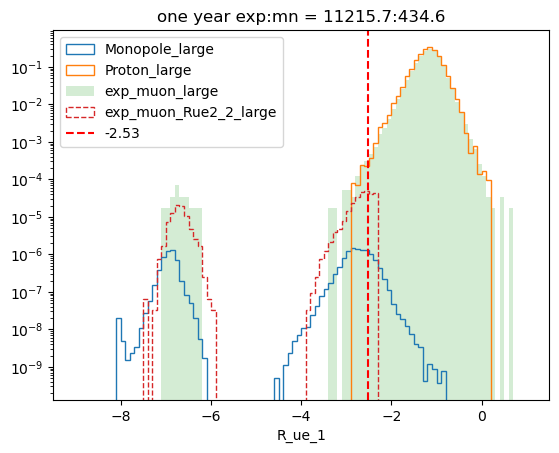

In [148]:
R_ue_cut_new=-2.53
exp_muon_Rue2_2_df_large_new = exp_muon_Rue2_2_df_large[exp_muon_Rue2_2_df_large['R_ue']<R_ue_cut_new]
mn_df_large_new = mn_df_large[mn_df_large['R_ue']<R_ue_cut_new]
plt.hist(mn_df_large['R_ue_1'], weights=mn_df_large['weight'], bins=100, histtype='step', label='Monopole_large', range=(-9, 1))
plt.hist(pr_df_large['R_ue_1'], weights=pr_df_large['gaisser_weight'], bins=100, histtype='step', label='Proton_large', range=(-9, 1))
plt.hist(exp_muon_df_large['R_ue_1'], weights=exp_muon_df_large['weight']*1.5, bins=100, histtype='stepfilled',alpha=0.2, label='exp_muon_large', range=(-9, 1))
plt.hist(exp_muon_Rue2_2_df_large_new['R_ue_1'], weights=exp_muon_Rue2_2_df_large_new['weight'], bins=100, histtype='step', linestyle='dashed', label='exp_muon_Rue2_2_large', range=(-9, 1))
plt.axvline(R_ue_cut_new, color='r', linestyle='--', label=f'{R_ue_cut_new}')
plt.legend()
plt.xlabel('R_ue_1')
plt.yscale('log')
plt.title(f"one year exp:mn = {exp_muon_Rue2_2_df_large_new['weight'].sum()*365*86400:.1f}:{mn_df_large_new['weight'].sum()*365*86400:.1f}")
plt.show()


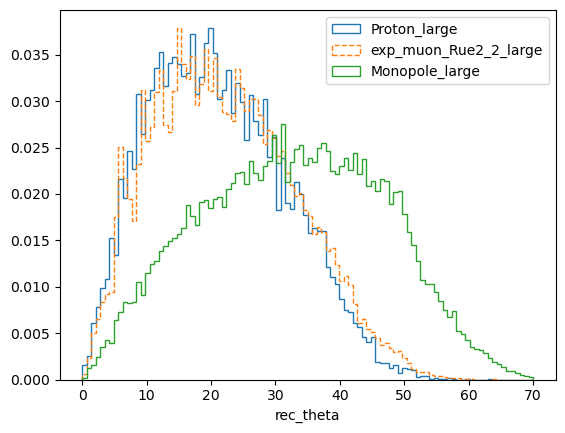

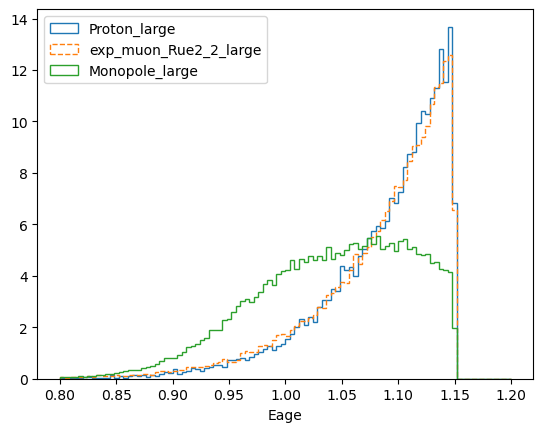

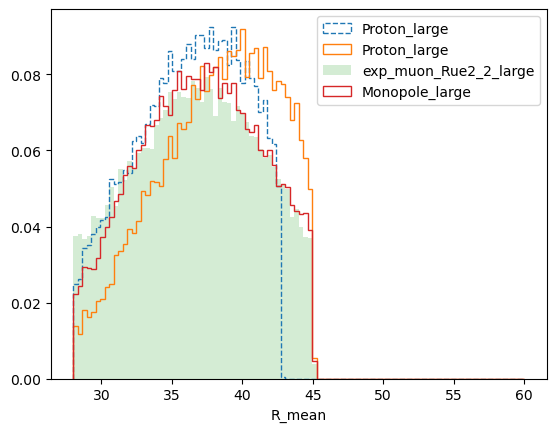

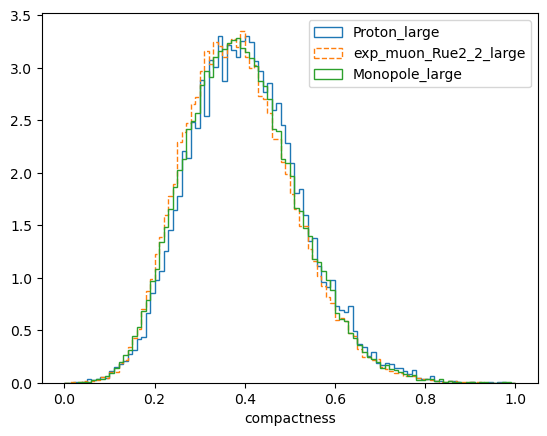

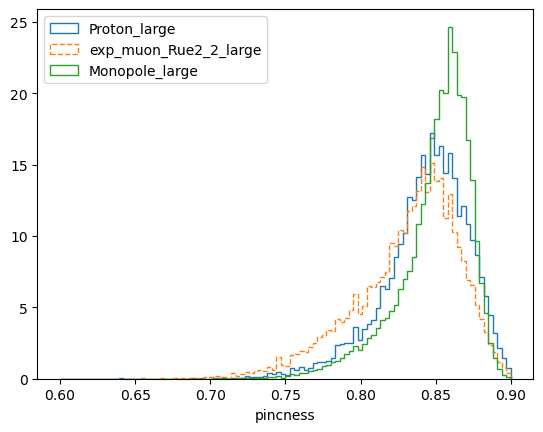

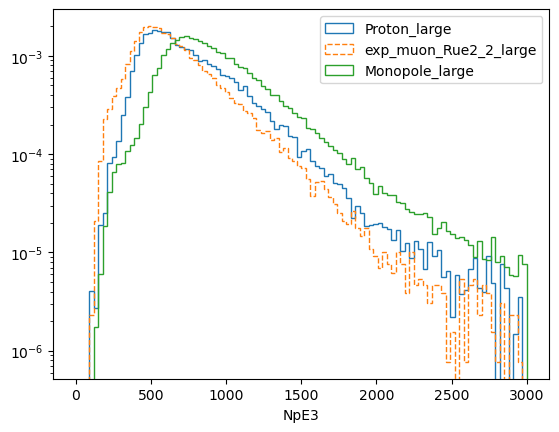

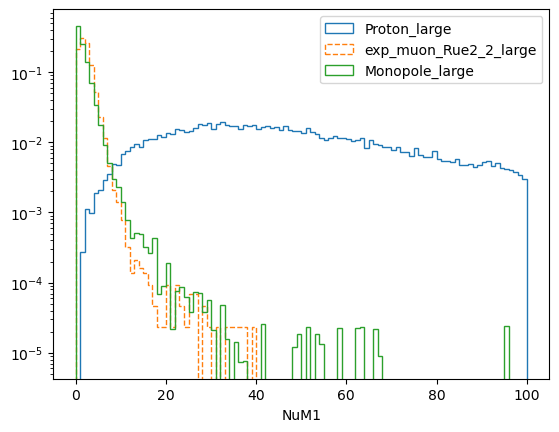

In [150]:
# histograms (density = True) of rec_theta Eage R_mean of pr_df, exp_muon_df and exp_muon_Rue2_2_df mn_df (and corresponding large area data) to compare
# rec_theta
# plt.hist(pr_df["rec_theta"]*180/np.pi, weights=pr_df['gaisser_weight'], bins=100, histtype='step', density=True, label='Proton', range=(0, 70))
# plt.hist(exp_muon_df["rec_theta"]*180/np.pi, weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled', density=True, alpha=0.3, label='exp_muon', range=(0, 70))
# plt.hist(exp_muon_Rue2_2_df["rec_theta"]*180/np.pi, weights=exp_muon_Rue2_2_df['weight'], bins=100, histtype='step', linestyle='dashed', density=True, label='exp_muon_Rue2_2', range=(0, 70))
# plt.hist(mn_df["rec_theta"]*180/np.pi, weights=mn_df['weight'], bins=100, histtype='step', density=True, label='Monopole', range=(0, 70))
# # large
plt.hist(pr_df_large["rec_theta"]*180/np.pi, weights=pr_df_large['gaisser_weight'], bins=100, histtype='step', density=True, label='Proton_large', range=(0, 70))
# plt.hist(exp_muon_df_large["rec_theta"]*180/np.pi, weights=exp_muon_df_large['weight']*1.5, bins=100, histtype='stepfilled', density=True, alpha=0.2, label='exp_muon_large', range=(0, 70))
plt.hist(exp_muon_Rue2_2_df_large["rec_theta"]*180/np.pi, weights=exp_muon_Rue2_2_df_large['weight'], bins=100, histtype='step', linestyle='dashed', density=True, label='exp_muon_Rue2_2_large', range=(0, 70))
plt.hist(mn_df_large["rec_theta"]*180/np.pi, weights=mn_df_large['weight'], bins=100, histtype='step', density=True, label='Monopole_large', range=(0, 70))
plt.legend()
plt.xlabel('rec_theta')
plt.show()

# Eage
Eage_range=(0.8, 1.2)
# plt.hist(pr_df['Eage'], weights=pr_df['gaisser_weight'], bins=100, histtype='step', density=True, label='Proton', range=Eage_range)
# plt.hist(exp_muon_df['Eage'], weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled', density=True, alpha=0.3, label='exp_muon', range=Eage_range)
# plt.hist(exp_muon_Rue2_2_df['Eage'], weights=exp_muon_Rue2_2_df['weight'], bins=100, histtype='step', linestyle='dashed', density=True, label='exp_muon_Rue2_2', range=Eage_range)
# plt.hist(mn_df['Eage'], weights=mn_df['weight'], bins=100, histtype='step', density=True, label='Monopole', range=Eage_range)
# large
plt.hist(pr_df_large['Eage'], weights=pr_df_large['gaisser_weight'], bins=100, histtype='step', density=True, label='Proton_large', range=Eage_range)
# plt.hist(exp_muon_df_large['Eage'], weights=exp_muon_df_large['weight']*1.5, bins=100, histtype='stepfilled', density=True, alpha=0.2, label='exp_muon_large', range=Eage_range)
plt.hist(exp_muon_Rue2_2_df_large['Eage'], weights=exp_muon_Rue2_2_df_large['weight'], bins=100, histtype='step', linestyle='dashed', density=True, label='exp_muon_Rue2_2_large', range=Eage_range)
plt.hist(mn_df_large['Eage'], weights=mn_df_large['weight'], bins=100, histtype='step', density=True, label='Monopole_large', range=Eage_range)
plt.legend()
plt.xlabel('Eage')
plt.show()

# R_mean
R_mean_range=(28,60)
# plt.hist(pr_df['R_mean'], weights=pr_df['gaisser_weight'], bins=100, histtype='step', density=True, label='Proton', range=R_mean_range)
# plt.hist(exp_muon_df['R_mean'], weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled', density=True, alpha=0.3, label='exp_muon', range=R_mean_range)
# plt.hist(exp_muon_Rue2_2_df['R_mean'], weights=exp_muon_Rue2_2_df['weight'], bins=100, histtype='step', linestyle='dashed', density=True, label='exp_muon_Rue2_2', range=R_mean_range)
# plt.hist(mn_df['R_mean'], weights=mn_df['weight'], bins=100, histtype='step', density=True, label='Monopole', range=R_mean_range)
# large
plt.hist(pr_df_large['R_mean']-2.278, weights=pr_df_large['gaisser_weight'], bins=100, histtype='step', linestyle='dashed',density=True, label='Proton_large', range=R_mean_range)
plt.hist(pr_df_large['R_mean'], weights=pr_df_large['gaisser_weight'], bins=100, histtype='step', density=True, label='Proton_large', range=R_mean_range)
# plt.hist(exp_muon_df_large['R_mean'], weights=exp_muon_df_large['weight']*1.5, bins=100, histtype='stepfilled', density=True, alpha=0.2, label='exp_muon_large', range=R_mean_range)
plt.hist(exp_muon_Rue2_2_df_large['R_mean'], weights=exp_muon_Rue2_2_df_large['weight'], bins=100, histtype='stepfilled',alpha=0.2, linestyle='dashed', density=True, label='exp_muon_Rue2_2_large', range=R_mean_range)
plt.hist(mn_df_large['R_mean'], weights=mn_df_large['weight'], bins=100, histtype='step', density=True, label='Monopole_large', range=R_mean_range)
plt.legend()
plt.xlabel('R_mean')
plt.show()

# compactness
compactness_range=(0.,1)
# plt.hist(pr_df['compactness'], weights=pr_df['gaisser_weight'], bins=100, histtype='step', density=True, label='Proton', range=compactness_range)
# plt.hist(exp_muon_df['compactness'], weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled', density=True, alpha=0.3, label='exp_muon', range=compactness_range)
# plt.hist(exp_muon_Rue2_2_df['compactness'], weights=exp_muon_Rue2_2_df['weight'], bins=100, histtype='step', linestyle='dashed', density=True, label='exp_muon_Rue2_2', range=compactness_range)
# plt.hist(mn_df['compactness'], weights=mn_df['weight'], bins=100, histtype='step', density=True, label='Monopole', range=compactness_range)
# large
plt.hist(pr_df_large['compactness'], weights=pr_df_large['gaisser_weight'], bins=100, histtype='step', density=True, label='Proton_large', range=compactness_range)
# plt.hist(exp_muon_df_large['compactness'], weights=exp_muon_df_large['weight']*1.5, bins=100, histtype='stepfilled', density=True, alpha=0.2, label='exp_muon_large', range=compactness_range)
plt.hist(exp_muon_Rue2_2_df_large['compactness'], weights=exp_muon_Rue2_2_df_large['weight'], bins=100, histtype='step', linestyle='dashed', density=True, label='exp_muon_Rue2_2_large', range=compactness_range)
plt.hist(mn_df_large['compactness'], weights=mn_df_large['weight'], bins=100, histtype='step', density=True, label='Monopole_large', range=compactness_range)
plt.legend()
plt.xlabel('compactness')
plt.show()

# pincness
pincness_range=(0.6,0.9)
# plt.hist(pr_df['pincness'], weights=pr_df['gaisser_weight'], bins=100, histtype='step', density=True, label='Proton', range=pincness_range)
# plt.hist(exp_muon_df['pincness'], weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled', density=True, alpha=0.3, label='exp_muon', range=pincness_range)
# plt.hist(exp_muon_Rue2_2_df['pincness'], weights=exp_muon_Rue2_2_df['weight'], bins=100, histtype='step', linestyle='dashed', density=True, label='exp_muon_Rue2_2', range=pincness_range)
# plt.hist(mn_df['pincness'], weights=mn_df['weight'], bins=100, histtype='step', density=True, label='Monopole', range=pincness_range)
# large
plt.hist(pr_df_large['pincness'], weights=pr_df_large['gaisser_weight'], bins=100, histtype='step', density=True, label='Proton_large', range=pincness_range)
# plt.hist(exp_muon_df_large['pincness'], weights=exp_muon_df_large['weight']*1.5, bins=100, histtype='stepfilled', density=True, alpha=0.2, label='exp_muon_large', range=pincness_range)
plt.hist(exp_muon_Rue2_2_df_large['pincness'], weights=exp_muon_Rue2_2_df_large['weight'], bins=100, histtype='step', linestyle='dashed', density=True, label='exp_muon_Rue2_2_large', range=pincness_range)
plt.hist(mn_df_large['pincness'], weights=mn_df_large['weight'], bins=100, histtype='step', density=True, label='Monopole_large', range=pincness_range)
plt.legend()
plt.xlabel('pincness')
plt.show()

# NpE3
NpE3_range=(0,3000)
# plt.hist(pr_df['NpE3'], weights=pr_df['gaisser_weight'], bins=100, histtype='step', density=True, label='Proton', range=NpE3_range)
# plt.hist(exp_muon_df['NpE3'], weights=exp_muon_df['weight']*1.5, bins=100, histtype='stepfilled', density=True, alpha=0.3, label='exp_muon', range=NpE3_range)
# plt.hist(exp_muon_Rue2_2_df['NpE3'], weights=exp_muon_Rue2_2_df['weight'], bins=100, histtype='step', linestyle='dashed', density=True, label='exp_muon_Rue2_2', range=NpE3_range)
# plt.hist(mn_df['NpE3'], weights=mn_df['weight'], bins=100, histtype='step', density=True, label='Monopole', range=NpE3_range)
# large
plt.hist(pr_df_large['NpE3'], weights=pr_df_large['gaisser_weight'], bins=100, histtype='step', density=True, label='Proton_large', range=NpE3_range)
# plt.hist(exp_muon_df_large['NpE3'], weights=exp_muon_df_large['weight']*1.5, bins=100, histtype='stepfilled', density=True, alpha=0.2, label='exp_muon_large', range=NpE3_range)
plt.hist(exp_muon_Rue2_2_df_large['NpE3'], weights=exp_muon_Rue2_2_df_large['weight'], bins=100, histtype='step', linestyle='dashed', density=True, label='exp_muon_Rue2_2_large', range=NpE3_range)
plt.hist(mn_df_large['NpE3'], weights=mn_df_large['weight'], bins=100, histtype='step', density=True, label='Monopole_large', range=NpE3_range)
plt.legend()
plt.yscale('log')
plt.xlabel('NpE3')
plt.show()
# NuM1
NuM1_range=(0,100)
plt.hist(pr_df_large['NuM1'], weights=pr_df_large['gaisser_weight'], bins=100, histtype='step', density=True, label='Proton_large', range=NuM1_range)
plt.hist(exp_muon_Rue2_2_df_large['NuM1'], weights=exp_muon_Rue2_2_df_large['weight'], bins=100, histtype='step', linestyle='dashed', density=True, label='exp_muon_Rue2_2_large', range=NuM1_range)
plt.hist(mn_df_large['NuM1'], weights=mn_df_large['weight'], bins=100, histtype='step', density=True, label='Monopole_large', range=NuM1_range)
plt.legend()
plt.yscale('log')
plt.xlabel('NuM1')
plt.show()


In [130]:
# exp_muon_Rue2_26_df_large=exp_muon_Rue2_2_df_large[exp_muon_Rue2_2_df_large['R_ue']<-2.6]
# exp_muon_Rue2_26_df_large['weight'].sum()/exp_muon_Rue2_2_df_large['weight'].sum()

mn_df_large_new = mn_df_large[(mn_df_large['R_mean']<45) & (mn_df_large['R_mean']>28)]
print(f'{mn_df_large_new["weight"].sum()/mn_df_large["weight"].sum():.2e}')
pr_df_large_new = pr_df_large[(pr_df_large['R_mean']<45) & (pr_df_large['R_mean']>28)]
print(f'{pr_df_large_new["gaisser_weight"].sum()/pr_df_large["gaisser_weight"].sum():.2e}')

# pr_df_large['R_mean'] 与 exp_Rue2_2_df_large['R_mean'] 分布整体差一个shift,请给出代码,确定pr_df_large['R_mean']的shift的最佳的值是多少
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance
from scipy.optimize import minimize_scalar

# 假设数据已经加载
# pr_series = pr_df_large['R_mean'].dropna()
# exp_series = exp_Rue2_2_df_large['R_mean'].dropna()

def find_best_shift(source_data, target_data):
    """
    通过最小化 Wasserstein 距离寻找最佳位移值 s
    使得 source_data + s 与 target_data 的分布最接近
    """
    
    # 定义目标函数：计算位移后的 Wasserstein 距离
    def objective(s):
        return wasserstein_distance(source_data + s, target_data)

    # 初始搜索范围可以基于均值之差
    mean_diff = target_data.mean() - source_data.mean()
    
    # 使用优化器寻找最小值
    # bracket 指定搜索的大致区间
    res = minimize_scalar(objective, bracket=(mean_diff - 1, mean_diff + 1))
    
    return res.x, res.fun

# 使用示例:
best_s, min_dist = find_best_shift(pr_df_large['R_mean'], exp_muon_Rue2_2_df_large['R_mean'])

print(f"最佳 Shift 值: {best_s}")
print(f"最小 Wasserstein 距离: {min_dist}")


7.97e-01
7.84e-01
最佳 Shift 值: -2.278140791278507
最小 Wasserstein 距离: 0.8982574228604909


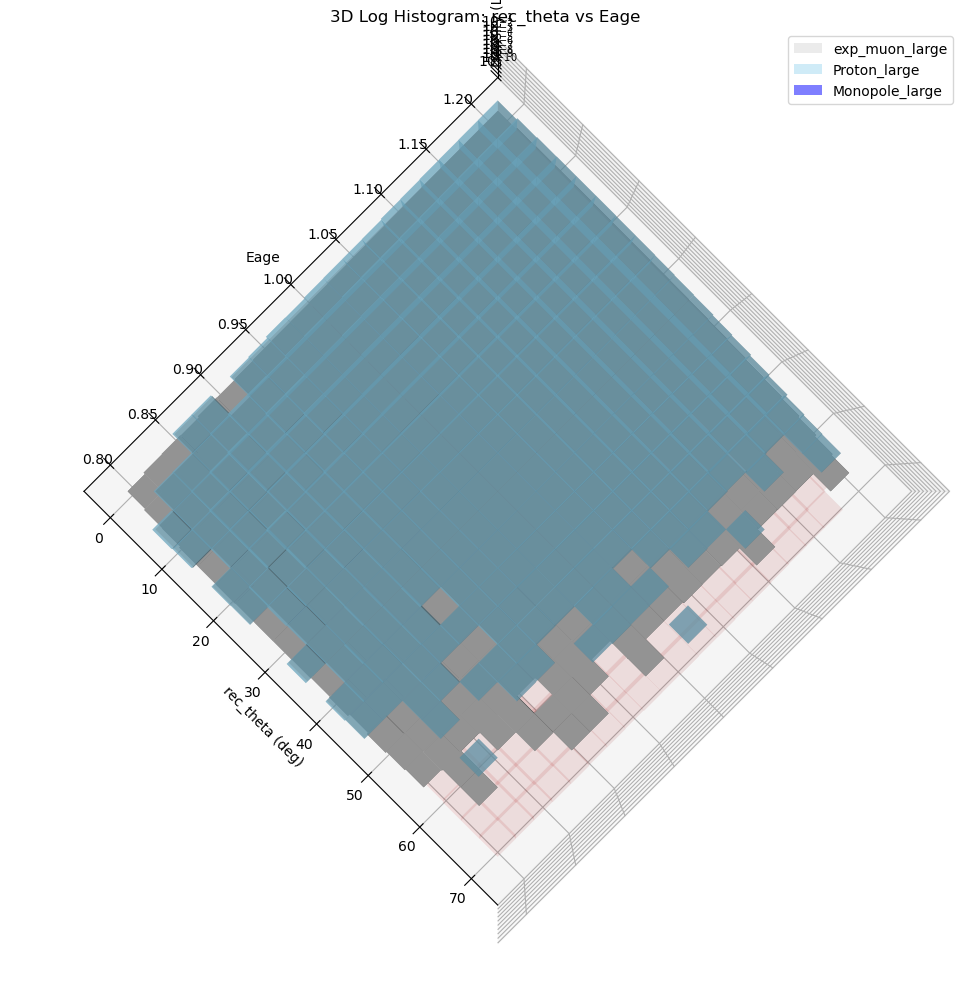

In [89]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch

# 创建画布
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# --- 参数设置 ---
bins_num = 20 # 稍微增加一点分辨率
range_theta = (0, 70)
range_eage = (0.8, 1.2)

# --- 核心配置：对数坐标的下限 ---
# 如果你的权重非常小（如 1e-10），这里设置更小的值，例如 -10
# 这里设置为 -6 意味着只显示 > 10^-6 的数据，小于此的视为底噪
LOG_FLOOR = -24

# --- 辅助函数：获取直方图数据 ---
def get_hist_data(df, weight_col, w_scale=1.0):
    x = df["rec_theta"] * 180 / np.pi
    y = df["Eage"]
    w = df[weight_col] * w_scale
    
    # 这里的 density=True/False 取决于你想看绝对数量还是归一化密度
    # 为了对比不同数量级的数据，建议用 density=True 或者保持 weights
    H, xedges, yedges = np.histogram2d(x, y, bins=bins_num, 
                                       range=[range_theta, range_eage], 
                                       weights=w, )
    return H, xedges, yedges

# --- 准备数据 ---
H_exp, xedges, yedges = get_hist_data(exp_muon_Rue2_2_df_large, 'weight',)
H_pr, _, _ = get_hist_data(pr_df_large, 'gaisser_weight')
H_mn, _, _ = get_hist_data(mn_df_large, 'weight')

# --- 构建网格坐标 ---
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()

# 计算每个柱子的宽度
dx = (xedges[1] - xedges[0])
dy = (yedges[1] - yedges[0])

# --- 绘图函数 (支持对数转换) ---
def plot_bars_log(ax, H, color, alpha, label):
    dz = H.ravel()
    
    # 1. 过滤掉 0 或极小值，避免 log(0) 报错
    # 任何小于 10^LOG_FLOOR 的值都视为 0
    mask = dz > (10**LOG_FLOOR)
    
    if np.sum(mask) == 0:
        return # 如果没有数据则跳过

    # 2. 取对数
    log_data = np.log10(dz[mask])
    
    # 3. 计算柱子高度
    # 柱子从 LOG_FLOOR 开始画，高度是 (当前值 - 底面)
    # 例如：数据是 10^-4 (log=-4)，底面是 -6，柱子高度就是 2
    heights = log_data - log_data.min()
    
    # 4. 绘制
    # z=LOG_FLOOR 确保柱子从设定的底面长出来
    ax.bar3d(xpos[mask], ypos[mask], log_data.min(), dx, dy, heights, 
             color=color, alpha=alpha, label=label, zsort='max')

# --- 绘制顺序 ---
# 1. exp_muon: 背景
plot_bars_log(ax, H_exp, color='silver', alpha=1, label='exp_muon_large')

# 2. Proton: 质子
plot_bars_log(ax, H_pr, color='skyblue', alpha=0.5, label='Proton_large')

# 3. Monopole: 信号 (稍微调高了一点 alpha 以便看见)
plot_bars_log(ax, H_mn, color='red', alpha=0.05, label='Monopole_large')

# --- 设置 Z 轴标签格式化 ---
# 这是一个 trick：将 Z 轴的刻度标签重写为 10^n 格式
def log_tick_formatter(val, pos=None):
    return f'$10^{{{int(val)}}}$'

ax.zaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))
ax.zaxis.set_major_locator(ticker.MaxNLocator(integer=True)) # 强制只显示整数刻度

# --- 标签与修饰 ---
ax.set_xlabel('rec_theta (deg)')
ax.set_ylabel('Eage')
ax.set_zlabel('Density (Log Scale)')
ax.set_title('3D Log Histogram: rec_theta vs Eage')

# 设置 Z 轴范围，确保底面干净
ax.set_zlim(None, None)

# 图例
legend_elements = [
    Patch(facecolor='silver', alpha=0.3, label='exp_muon_large'),
    Patch(facecolor='skyblue', alpha=0.4, label='Proton_large'),
    Patch(facecolor='blue', alpha=0.5, label='Monopole_large')
]
ax.legend(handles=legend_elements)

# 调整视角
ax.view_init(elev=90, azim=-45)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import os
# /home/zhonghua/data/Dataset_Filted/CosmicRay/QF_CNO_addweight_rho_2.5e13_5.0e17_V3.root
# /home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Fe_addweight_rho_2.5e13_5.0e17_V3.root
# /home/zhonghua/data/Dataset_Filted/CosmicRay/QF_He_addweight_rho_2.5e13_5.0e17_V3.root
# /home/zhonghua/data/Dataset_Filted/CosmicRay/QF_MgAlSi_addweight_rho_2.5e13_5.0e17_V3.root
# /home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Proton_addweight_rho_2.5e13_5.0e17_V3.root
r_cut_low=320
r_cut_high=420
theta_cut_low=10/180*np.pi
theta_cut_high=30/180*np.pi

def open_file(file_name):
    with uproot.open(file_name) as file:
        tree = file["Rec"]
        branches_to_read = ["E", "theta","phi","corex","corey","rec_x","rec_y","rec_theta","rec_phi","rec_Eage","Redge","NpE3","NuM2","NuW3","weightGaisser"]
        df = tree.arrays(branches_to_read, library="pd")
        all_weights = df['weightGaisser'].sum()
        print(file_name)
        print("     Entries:", tree.num_entries)
        print("     Total weights:", all_weights)
        cuts_indices = (df['rec_Eage'] > 0) & (df['Redge'] > 0) & (df['rec_theta'] > theta_cut_low) & (df['rec_theta'] < theta_cut_high)  & (df["NuW3"]>0)
        df_cut = df[cuts_indices].copy() 
        
        df_cut["R_ue"]=np.log10((1e-4+df_cut["NuM2"])/(df_cut["NpE3"]+1))
        print(f"     Entries after cut: {df_cut.shape[0]}")
        del df
        return df_cut
    

def energy_correction(df: pd.DataFrame):
    theta=df["rec_theta"].values
    # df["NuW3"]  theta 作为输入
    log10_NuW3 = np.log10(df["NuW3"].values)
    feature_data = np.column_stack((log10_NuW3, theta))
    corrected_energy = model.predict(feature_data)
    df["recE"]=corrected_energy  # log10(TeV)
    log10TeV_low=1.8629710674285889
    log10TeV_high=2.2981839179992676
    # 筛选
    df_new=df[(df["recE"]>log10TeV_low) & (df["recE"]<log10TeV_high)]
    del df
    return df_new

proton_df_QF = open_file("/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Proton_addweight_rho_2.5e13_5.0e17_V3.root")
he_df = open_file("/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_He_addweight_rho_2.5e13_5.0e17_V3.root")
cno_df = open_file("/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_CNO_addweight_rho_2.5e13_5.0e17_V3.root")
fe_df = open_file("/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Fe_addweight_rho_2.5e13_5.0e17_V3.root")
mgalsi_df = open_file("/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_MgAlSi_addweight_rho_2.5e13_5.0e17_V3.root")

from xgboost import XGBRegressor
model = XGBRegressor()
model.load_model("/home/zhonghua/Filt_Event/recE/models/energy_correction_xgb_NuW3_8-12_higher.json")

proton_df_QF=energy_correction(proton_df_QF)
he_df=energy_correction(he_df)
cno_df=energy_correction(cno_df)
fe_df=energy_correction(fe_df)
mgalsi_df=energy_correction(mgalsi_df)

proton_df_QF["r"]=np.sqrt(proton_df_QF['rec_x']**2+proton_df_QF['rec_y']**2)
he_df["r"]=np.sqrt(he_df['rec_x']**2+he_df['rec_y']**2)
cno_df["r"]=np.sqrt(cno_df['rec_x']**2+cno_df['rec_y']**2)
fe_df["r"]=np.sqrt(fe_df['rec_x']**2+fe_df['rec_y']**2)
mgalsi_df["r"]=np.sqrt(mgalsi_df['rec_x']**2+mgalsi_df['rec_y']**2)

proton_df_QF=proton_df_QF[(proton_df_QF["r"]>r_cut_low) & (proton_df_QF["r"]<r_cut_high)]
he_df=he_df[(he_df["r"]>r_cut_low) & (he_df["r"]<r_cut_high)]
cno_df=cno_df[(cno_df["r"]>r_cut_low) & (cno_df["r"]<r_cut_high)]
fe_df=fe_df[(fe_df["r"]>r_cut_low) & (fe_df["r"]<r_cut_high)]
mgalsi_df=mgalsi_df[(mgalsi_df["r"]>r_cut_low) & (mgalsi_df["r"]<r_cut_high)]



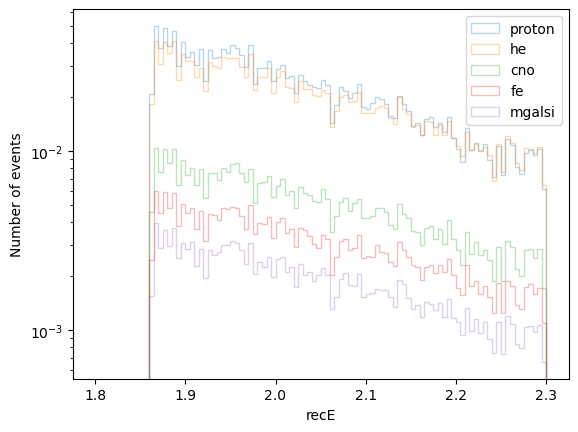

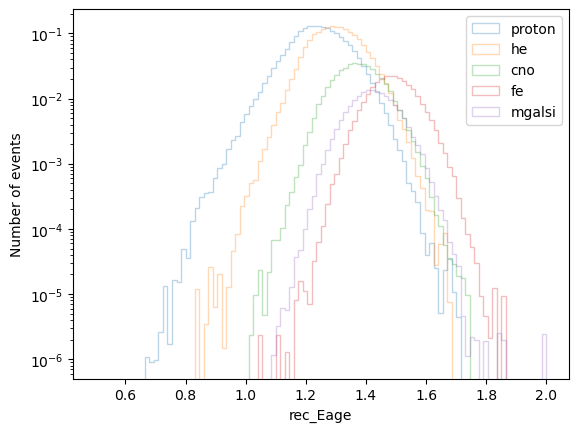

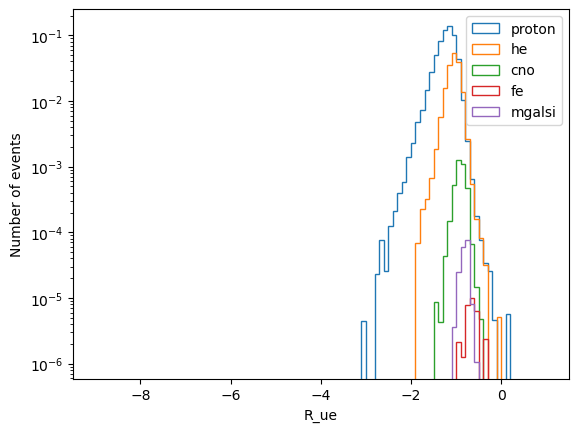

In [ ]:
# plt.hist  five typies of cosmic rays recE with weights, bins=100, range=type_range (suitable range), ylog scale
# recE rec_Eage
#  R_ue dis after recE and rec_Eage cuts, recE cut done, recE_age range (0.8,1.2) generate 
recE_range=(1.8,2.3); Eage_range=(0.5,2); R_ue_range=(-9,1)
Eage_low=0.8; Eage_high=1.2
# recE
plt.hist(proton_df_QF["recE"], weights=proton_df_QF["weightGaisser"], bins=100, range=recE_range, histtype='step',alpha=0.3, label='proton')
plt.hist(he_df["recE"], weights=he_df["weightGaisser"], bins=100, range=recE_range, histtype='step',alpha=0.3, label='he')
plt.hist(cno_df["recE"], weights=cno_df["weightGaisser"], bins=100, range=recE_range, histtype='step',alpha=0.3, label='cno')
plt.hist(fe_df["recE"], weights=fe_df["weightGaisser"], bins=100, range=recE_range, histtype='step',alpha=0.3, label='fe')
plt.hist(mgalsi_df["recE"], weights=mgalsi_df["weightGaisser"], bins=100, range=recE_range, histtype='step',alpha=0.3, label='mgalsi')
plt.legend()
plt.yscale('log')
plt.xlabel('recE')
plt.ylabel('Number of events')
plt.show()
# rec_Eage
plt.hist(proton_df_QF["rec_Eage"], weights=proton_df_QF["weightGaisser"], bins=100, range=Eage_range, histtype='step',alpha=0.3, label='proton')
plt.hist(he_df["rec_Eage"], weights=he_df["weightGaisser"], bins=100, range=Eage_range, histtype='step',alpha=0.3, label='he')
plt.hist(cno_df["rec_Eage"], weights=cno_df["weightGaisser"], bins=100, range=Eage_range, histtype='step',alpha=0.3, label='cno')
plt.hist(fe_df["rec_Eage"], weights=fe_df["weightGaisser"], bins=100, range=Eage_range, histtype='step',alpha=0.3, label='fe')
plt.hist(mgalsi_df["rec_Eage"], weights=mgalsi_df["weightGaisser"], bins=100, range=Eage_range, histtype='step',alpha=0.3, label='mgalsi')
plt.legend()
plt.yscale('log')
plt.xlabel('rec_Eage')
plt.ylabel('Number of events')
plt.show()

# R_ue dis after recE and rec_Eage cuts, recE cut done, recE_age range (0.8,1.2) generate
proton_df_recE_age = proton_df_QF[(proton_df_QF["rec_Eage"]>Eage_low) & (proton_df_QF["rec_Eage"]<Eage_high)]
he_df_recE_age = he_df[(he_df["rec_Eage"]>Eage_low) & (he_df["rec_Eage"]<Eage_high)]
cno_df_recE_age = cno_df[(cno_df["rec_Eage"]>Eage_low) & (cno_df["rec_Eage"]<Eage_high)]
fe_df_recE_age = fe_df[(fe_df["rec_Eage"]>Eage_low) & (fe_df["rec_Eage"]<Eage_high)]
mgalsi_df_recE_age = mgalsi_df[(mgalsi_df["rec_Eage"]>Eage_low) & (mgalsi_df["rec_Eage"]<Eage_high)]
# R_ue
plt.hist(proton_df_recE_age["R_ue"], weights=proton_df_recE_age["weightGaisser"], bins=100, range=R_ue_range, histtype='step',alpha=1, label='proton')
plt.hist(he_df_recE_age["R_ue"], weights=he_df_recE_age["weightGaisser"], bins=100, range=R_ue_range, histtype='step',alpha=1, label='he')
plt.hist(cno_df_recE_age["R_ue"], weights=cno_df_recE_age["weightGaisser"], bins=100, range=R_ue_range, histtype='step',alpha=1, label='cno')
plt.hist(fe_df_recE_age["R_ue"], weights=fe_df_recE_age["weightGaisser"], bins=100, range=R_ue_range, histtype='step',alpha=1, label='fe')
plt.hist(mgalsi_df_recE_age["R_ue"], weights=mgalsi_df_recE_age["weightGaisser"], bins=100, range=R_ue_range, histtype='step',alpha=1, label='mgalsi')
plt.legend()
plt.yscale('log')
plt.xlabel('R_ue')
plt.ylabel('Number of events')
plt.show()


In [ ]:

percent=95
rec_r = mn_good['rec_r'].values
rec_r_range = (0, 700)
plt.hist(mn_df['rec_r'], weights=mn_df['weight'], bins=50, range=rec_r_range, histtype='step', label='Monopole')
plt.hist(mn_good['rec_r'], weights=mn_good['weight'], bins=50, range=rec_r_range, histtype='step', label='Good')
# plt.axvline(x=np.percentile(rec_r, percent), color='r', linestyle='--', label=f'{percent}% containment radius={np.percentile(rec_r, percent)} m')
plt.xlabel('Radius (m)')
plt.ylabel('Number of events')
# plt.xticks(range(0, 20, 1))
plt.legend()
plt.show()
theta_range=(0,70)
plt.hist(mn_df['rec_theta'].values * 180 / np.pi, weights=mn_df['weight'], range=theta_range, bins=50, histtype='step', label='Monopole')
plt.hist(mn_good['rec_theta'].values * 180 / np.pi, weights=mn_good['weight'], range=theta_range, bins=50,histtype='step', label='Good')
plt.xlabel('Zenith angle (degrees)')
plt.ylabel('Number of events')
# plt.xticks(range(0, 20, 1))
plt.legend()
plt.show()
# rec_theta *180 / np.pi [0-30] [30-50] [50-90]
mn_df_0_30 = mn_df[(mn_df['rec_theta'] *180 / np.pi >= 0) & (mn_df['rec_theta'] *180 / np.pi < 30)]
mn_df_30_50 = mn_df[(mn_df['rec_theta'] *180 / np.pi >= 30) & (mn_df['rec_theta'] *180 / np.pi < 50)]
mn_df_50_90 = mn_df[(mn_df['rec_theta'] *180 / np.pi >= 50) & (mn_df['rec_theta'] *180 / np.pi < 90)]
# Eage dis
Eage_range=(0.6,2)
plt.hist(mn_df['Eage'], weights=mn_df['weight'], bins=50, range=Eage_range, histtype='step', label='Monopole')
plt.hist(mn_good['Eage'], weights=mn_good['weight'], bins=50, range=Eage_range, histtype='step', label='Good')
plt.hist(mn_df_0_30['Eage'], weights=mn_df_0_30['weight'], bins=50, range=Eage_range, histtype='step', label='0-30')
plt.hist(mn_df_30_50['Eage'], weights=mn_df_30_50['weight'], bins=50, range=Eage_range, histtype='step', label='30-50')
plt.hist(mn_df_50_90['Eage'], weights=mn_df_50_90['weight'], bins=50, range=Eage_range, histtype='step', label='50-90')
plt.legend()
plt.xlabel('Eage')
plt.ylabel('Number of events')
plt.show()
# R_mean
R_mean_range=(0,150)
plt.hist(mn_df['R_mean'], weights=mn_df['weight'], bins=50, range=R_mean_range, histtype='step', label='Monopole')
plt.hist(mn_good['R_mean'], weights=mn_good['weight'], bins=50, range=R_mean_range, histtype='step', label='Good')
plt.hist(mn_df_0_30['R_mean'], weights=mn_df_0_30['weight'], bins=50, range=R_mean_range, histtype='step', label='0-30')
plt.hist(mn_df_30_50['R_mean'], weights=mn_df_30_50['weight'], bins=50, range=R_mean_range, histtype='step', label='30-50')
plt.hist(mn_df_50_90['R_mean'], weights=mn_df_50_90['weight'], bins=50, range=R_mean_range, histtype='step', label='50-90')
plt.legend()
plt.xlabel('R_mean')
plt.ylabel('Number of events')
plt.show()
# compactness
compactness_range=(0,1)
plt.hist(mn_df['compactness'], weights=mn_df['weight'], bins=50, range=compactness_range, histtype='step', label='Monopole')
plt.hist(mn_good['compactness'], weights=mn_good['weight'], bins=50, range=compactness_range, histtype='step', label='Good')
plt.hist(mn_df_0_30['compactness'], weights=mn_df_0_30['weight'], bins=50, range=compactness_range, histtype='step', label='0-30')
plt.hist(mn_df_30_50['compactness'], weights=mn_df_30_50['weight'], bins=50, range=compactness_range, histtype='step', label='30-50')
plt.hist(mn_df_50_90['compactness'], weights=mn_df_50_90['weight'], bins=50, range=compactness_range, histtype='step', label='50-90')
plt.legend()
plt.xlabel('compactness')
plt.ylabel('Number of events')
plt.show()
# pincness
pincness_range=(0.4,1)
plt.hist(mn_df['pincness'], weights=mn_df['weight'], bins=50, range=pincness_range, histtype='step', label='Monopole')
plt.hist(mn_good['pincness'], weights=mn_good['weight'], bins=50, range=pincness_range, histtype='step', label='Good')
plt.hist(mn_df_0_30['pincness'], weights=mn_df_0_30['weight'], bins=50, range=pincness_range, histtype='step', label='0-30')
plt.hist(mn_df_30_50['pincness'], weights=mn_df_30_50['weight'], bins=50, range=pincness_range, histtype='step', label='30-50')
plt.hist(mn_df_50_90['pincness'], weights=mn_df_50_90['weight'], bins=50, range=pincness_range, histtype='step', label='50-90')
plt.legend()
plt.xlabel('pincness')
plt.ylabel('Number of events')
plt.show()



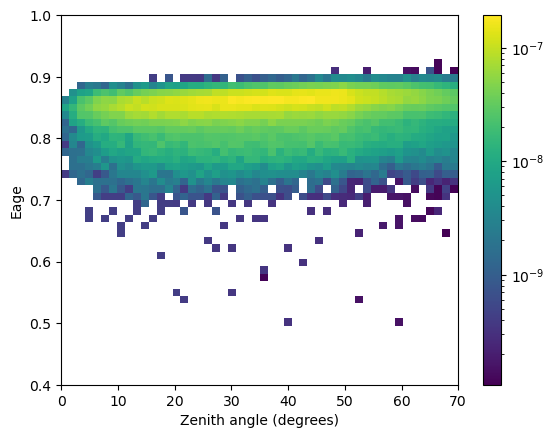

In [ ]:
# log  colorbar
from matplotlib.colors import LogNorm
theta_range=(0,70);Eage_range=(0.7,1.3);pincness_range=(0.4,1)
plt.hist2d(mn_good['rec_theta'].values * 180 / np.pi, mn_good['pincness'].values, weights=mn_good['weight'], bins=[50, 50], range=[theta_range, pincness_range], cmap='viridis', norm=LogNorm())
plt.colorbar()
plt.xlabel('Zenith angle (degrees)')
plt.ylabel('Eage')
plt.show()


In [ ]:
mn_good['pincness'].describe()


count     82153.000000
unique     9834.000000
top           0.857143
freq        890.000000
Name: pincness, dtype: float64

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def check_correlation(df, x_col, y_col, w_col=None, x_label='X', y_label='Y', bins=10):
    """
    计算加权相关系数并绘制 Profile Plot
    """
    x = df[x_col].values
    y = df[y_col].values
    
    # 处理权重：如果没有权重，设为全1
    if w_col is not None:
        w = df[w_col].values
    else:
        w = np.ones_like(x)

    # ==========================================
    # 1. 计算加权 Pearson 相关系数
    # ==========================================
    # np.cov 返回协方差矩阵，aweights 参数用于处理权重
    cov_matrix = np.cov(x, y, aweights=w) 
    # 相关系数 = Cov(X,Y) / (sigma_X * sigma_Y)
    corr_coef = cov_matrix[0, 1] / np.sqrt(cov_matrix[0, 0] * cov_matrix[1, 1])
    
    print("="*40)
    print(f"变量: {x_label} vs {y_label}")
    print(f"加权 Pearson 相关系数 (rho): {corr_coef:.4f}")
    
    if abs(corr_coef) < 0.05:
        print("结论: 相关性很弱 (适合 ABCD)")
    else:
        print("结论: 存在一定相关性 (需谨慎使用 ABCD)")
    print("="*40)

    # ==========================================
    # 2. 绘制 Profile Plot (Mean Y vs X)
    # ==========================================
    # 定义 X 的分桶
    x_min, x_max = np.min(x), np.max(x)
    bin_edges = np.linspace(x_min, x_max, bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    mean_y = []
    err_y = []
    
    # 遍历每个 bin 计算加权平均值
    for i in range(bins):
        # 找到落在当前 bin 的数据的索引
        mask = (x >= bin_edges[i]) & (x < bin_edges[i+1])
        
        if np.sum(mask) > 0:
            y_in_bin = y[mask]
            w_in_bin = w[mask]
            
            # 加权平均: sum(w*y) / sum(w)
            weighted_mean = np.average(y_in_bin, weights=w_in_bin)
            
            # 加权标准误 (Standard Error of Mean): sqrt(sum(w * (y - mean)^2) / (sum(w) * (N-1)/N )) 
            # 简化版估算: std / sqrt(N_eff)
            variance = np.average((y_in_bin - weighted_mean)**2, weights=w_in_bin)
            std_dev = np.sqrt(variance)
            # 有效样本数近似
            N_eff = (np.sum(w_in_bin)**2) / np.sum(w_in_bin**2)
            error = std_dev / np.sqrt(N_eff)
            
            mean_y.append(weighted_mean)
            err_y.append(error)
        else:
            mean_y.append(np.nan)
            err_y.append(np.nan)

    # 绘图
    plt.figure(figsize=(8, 6))
    
    # 背景画原来的散点图或hist2d作为参考（可选）
    # plt.hist2d(x, y, weights=w, bins=50, cmap='Greys', norm=LogNorm(), alpha=0.3)
    
    # 画 Profile 点
    plt.errorbar(bin_centers, mean_y, yerr=err_y, fmt='o-', color='red', label='Profile (Mean Y)')
    
    # 画一条水平辅助线（代表整体平均值），用于对比是否平坦
    global_mean = np.average(y, weights=w)
    plt.axhline(global_mean, color='blue', linestyle='--', label=f'Global Mean:{global_mean:.3f}')

    plt.title(f'Profile Plot: Correlation = {corr_coef:.3f}')
    plt.xlabel(x_label)
    plt.ylabel(f'Mean {y_label}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def check_correlation_robust(df, x_col, y_col, w_col=None):
    # 1. 强制复制并清理数据
    cols = [x_col, y_col]
    if w_col: cols.append(w_col)
    
    # 剔除 NaN 和 Inf
    data = df[cols].copy().replace([np.inf, -np.inf], np.nan).dropna()
    
    if len(data) < 2:
        print("错误: 有效数据量不足（少于2行）")
        return
        
    x = data[x_col].values
    y = data[y_col].values
    w = data[w_col].values if w_col else np.ones_like(x)

    # 2. 检查方差
    if np.std(x) == 0 or np.std(y) == 0:
        print("警告: 其中一个变量是常量（标准差为0），无法计算相关系数。")
        return

    # 3. 计算加权协方差
    try:
        cov_matrix = np.cov(x, y, aweights=w)
        corr_coef = cov_matrix[0, 1] / np.sqrt(cov_matrix[0, 0] * cov_matrix[1, 1])
        print(f"加权 Pearson 相关系数 (rho): {corr_coef:.4f}")
    except Exception as e:
        print(f"计算出错: {e}")

# 调用方法

mn_good['theta_deg'] = mn_good['rec_theta'] * 180 / np.pi

check_correlation_robust(mn_good, 'theta_deg', 'pincness', 'weight')

# check_correlation(
#     mn_good, 
#     x_col='theta_deg', 
#     y_col='pincness', 
#     w_col='weight', 
#     x_label='Zenith Angle (deg)', 
#     y_label='Eage'
# )


加权 Pearson 相关系数 (rho): 0.1368


/tmp/ipykernel_3576514/4215946476.py:99: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = df[cols].copy().replace([np.inf, -np.inf], np.nan).dropna()


尖峰区域: [16.4, 17.1] 度
背景密度: 1250.00 events/deg
尖峰密度: 2461.43 events/deg
建议保留比例 (Keep Ratio): 0.4317
原始事件数: 104811
处理后事件数: 103839
移除了 972 个异常事件


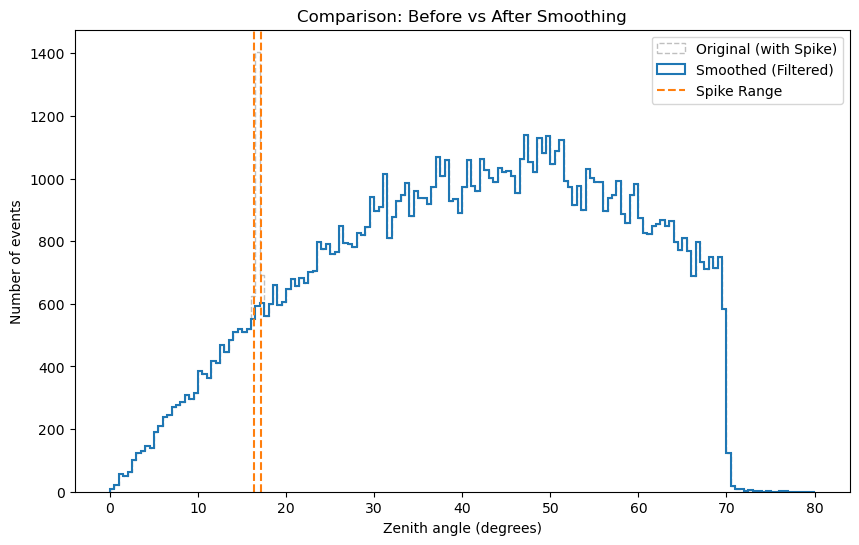

新文件已保存至: /home/zhonghua/data/Dataset_Filted/Monopole/filted_Monopole_1e10_merged_1000_70_dataset_muon_smooth.npz


In [1]:

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. 加载数据
file_path = "/home/zhonghua/data/Dataset_Filted/Monopole/filted_Monopole_1e10_merged_1000_70_dataset_fastcode.npz"
mn_data = np.load(file_path, allow_pickle=True)
hitsE = mn_data['hitsE']; hitsM = mn_data['hitsM']
params = mn_data['params']
param_names = mn_data['param_names']

# 转为 DataFrame 方便操作
mn_df = pd.DataFrame(params, columns=param_names)

# 计算角度（用于筛选）
theta_deg = mn_df['rec_theta'].values * 180 / np.pi

# ==========================================
# 2. 定义尖峰范围和背景范围 (根据你的图目测)
# ==========================================
# 尖峰中心大约在 17 度，宽度看起来很窄
spike_low  = 16.4
spike_high = 17.1

# 用来计算“正常水平”的邻域范围 (Sidebands)
# 选取尖峰左右两边比较平滑的区域
bg_range_mask = (
    ((theta_deg >= 16.) & (theta_deg < spike_low)) | 
    ((theta_deg > spike_high) & (theta_deg <= 17.5)) 
)

# ==========================================
# 3. 计算保留概率
# ==========================================

# 统计邻域内的平均密度 (events per degree)
bg_events_count = np.sum(bg_range_mask)
bg_width = (spike_low - 16.) + (17.5 - spike_high)
bg_density = bg_events_count / bg_width  # 单位：事件数/度

# 统计尖峰区域内的当前密度
spike_mask = (theta_deg >= spike_low) & (theta_deg <= spike_high)
spike_events_count = np.sum(spike_mask)
spike_width = spike_high - spike_low
current_spike_density = spike_events_count / spike_width 

# 计算保留比例 (Keep Ratio)
# 如果尖峰密度比背景大，就需要降采样；如果反而小了(不太可能)，就全保留(ratio=1)
if current_spike_density > bg_density:
    keep_ratio = bg_density / current_spike_density *0.85
else:
    keep_ratio = 1.0

print(f"尖峰区域: [{spike_low}, {spike_high}] 度")
print(f"背景密度: {bg_density:.2f} events/deg")
print(f"尖峰密度: {current_spike_density:.2f} events/deg")
print(f"建议保留比例 (Keep Ratio): {keep_ratio:.4f}")

# ==========================================
# 4. 执行“抹平”操作
# ==========================================

# 生成一个随机数数组，长度等于总数据量
random_probs = np.random.rand(len(mn_df))

# 构建最终的筛选 Mask
# 逻辑：
# 1. 如果不在尖峰区域 -> 也就是 (NOT spike_mask) -> 全部保留 (True)
# 2. 如果在尖峰区域 -> 只有当 random_probs < keep_ratio 时保留
final_mask = (~spike_mask) | (random_probs < keep_ratio)

# 应用筛选
mn_df_cleaned = mn_df[final_mask]
hitsE_cleaned = hitsE[final_mask]
hitsM_cleaned = hitsM[final_mask]

print(f"原始事件数: {len(mn_df)}")
print(f"处理后事件数: {len(mn_df_cleaned)}")
print(f"移除了 {len(mn_df) - len(mn_df_cleaned)} 个异常事件")

# ==========================================
# 5. 画图对比 (检查效果)
# ==========================================
plt.figure(figsize=(10, 6))

# 原始数据
plt.hist(theta_deg, range=[0, 80], bins=160, 
         histtype='step', color='gray', linestyle='--', label='Original (with Spike)', alpha=0.5)

# 处理后数据
cleaned_theta = mn_df_cleaned['rec_theta'].values * 180 / np.pi
plt.hist(cleaned_theta, range=[0, 80], bins=160, 
         histtype='step', color='tab:blue', linewidth=1.5, label='Smoothed (Filtered)')

plt.axvline(spike_low, color='tab:orange', linestyle='--', label='Spike Range')
plt.axvline(spike_high, color='tab:orange', linestyle='--')
plt.xlabel('Zenith angle (degrees)')
plt.ylabel('Number of events')
plt.title('Comparison: Before vs After Smoothing')
plt.legend()
plt.show()

# ==========================================
# 6. 保存新的 npz 文件
# ==========================================
# 假设你想保存回同样的格式
save_path = "/home/zhonghua/data/Dataset_Filted/Monopole/filted_Monopole_1e10_merged_1000_70_dataset_muon_smooth.npz"

np.savez(
    save_path, 
    hitsE = hitsE_cleaned,
    hitsM = hitsM_cleaned,
    params=mn_df_cleaned.values,  # 保存过滤后的 numpy 数组
    param_names=param_names       # 保持列名不变
)

print(f"新文件已保存至: {save_path}")



In [ ]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def give_weights(params_df):
    rootfile = "/home/zhonghua/data/exposure.root"
    with uproot.open(rootfile) as f:
        hWeight = f["hWeight"]
        edges_E = hWeight.axes[0].edges()  # Energy bin edges
        edges_Zen = hWeight.axes[1].edges()  # Zenith bin edges
        weights_2d = hWeight.values()

    def add_weights(trueE, rec_zenith, weights_2d):
        trueE = np.asarray(trueE, dtype=float)
        trueE=np.log10(trueE/1e3)
        rec_zenith=180/np.pi*rec_zenith
        bin_idx_E = np.digitize(trueE, edges_E) - 1 
        bin_idx_Zen = np.digitize(rec_zenith, edges_Zen) - 1
        
        return weights_2d[bin_idx_E, bin_idx_Zen] / 10 
    trueE = params_df['trueE'].values
    rec_zenith = params_df['theta'].values
    weights = add_weights(trueE, rec_zenith, weights_2d)
    params_df['weight'] = weights
    return params_df

def give_sig_weights(monopole_df):
    file = uproot.open("/home/zhonghua/Filt_Event/model_validation/exposure.root")
    h1 = file["h1"]
    h2 = file["h2"]
    # 获取直方图的所有数据
    values = h1.values()        # bin内容（纵坐标）
    h2_values = h2.values()        # bin内容（纵坐标）
    edges = h1.axis().edges()   # bin边界（横坐标）
    h2_edges = h2.axis().edges()   # bin边界（横坐标）
    centers = h1.axis().centers()  # bin中心
    h2_centers = h2.axis().centers()  # bin中心

    values = np.array(h1.values())
    edges = np.array(h1.axis().edges())
    centers = np.array(h1.axis().centers())
    S=np.pi * 1000**2
    parker=1e-15 * 1e4 
    nums=[]
    for i, theta in enumerate(centers):
        cosine_theta = np.cos(np.deg2rad(theta))
        area = S * cosine_theta
        exposure = values[i] * area
        num_i = exposure * parker
        nums.append(num_i)

    weights=[num_i/251000/h2_values[i]/86400 for i, num_i in enumerate(nums)]
    theta_degrees = monopole_df["theta"] * 180 / np.pi
    monopole_weights = []
    for theta in theta_degrees:
        if theta > max(centers) or theta < 0:
            weight = weights[-1] if theta > max(centers) else 0
        else:
            bin_id = np.digitize(theta, edges) - 1
            weight = weights[bin_id]
        monopole_weights.append(weight)
  
    monopole_df["weight"] = monopole_weights

    return monopole_df


156769.56666126644 99750.7997431037 256520.36640437017
0.3888611307605099
0.61113886923949
0.47904770484827425


In [ ]:
# pre_data
import numpy as np
import pandas as pd


r_low=300
r_high=500
theta_low=0
theta_high=50 / 180.0 * np.pi

Rmean_low=25
Rmean_high=45.0
Eage_low=0.8
Eage_high=1.2
R_ue_high=-5.0
log10TeV_low=1.79
log10TeV_high=2.1131057739257812


def filter_dataset_optimized(npz_file, output_file, mc=True):
    # param_names=["label","weight",
    #                 "R_ue", "R_mean", "Eage",
    #                 "recE", "rec_x", "rec_y", "rec_theta", "rec_phi", 
    #                 "trueE", "NuW2", "NpE3", "NuM1", "core_x","core_y","theta"]
    data = np.load(npz_file, allow_pickle=True)
    params = data["params"]
    params_df = pd.DataFrame(params, columns=data["param_names"])
    
    initial_count = len(params)
    current_mask = np.ones(initial_count, dtype=bool)
    
   
    recE= params_df["recE"].values
    R_ue =  params_df["R_ue"].values
    R_mean = params_df["R_mean"].values
    Eage = params_df["Eage"].values
    rec_x = params_df["rec_x"].values
    rec_y = params_df["rec_y"].values
    
    # 向量化计算 r
    r = np.sqrt(rec_x**2 + rec_y**2)

    # --------------------------------------------------
    # 顺序筛选与打印比例
    # --------------------------------------------------
    print(f"--- 原始数据量: {initial_count} ---")
    
    # 1. 筛选 r (r_low < r < r_high)
    r_mask = (r > r_low) & (r < r_high)
    n_last = current_mask.sum()
    current_mask = current_mask & r_mask
    n_after = current_mask.sum()
    print(f"1. Cut r: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # 2. 筛选 theta (theta_low < theta < theta_high)
    theta_mask = (params[:, 8] > theta_low) & (params[:, 8] < theta_high)
    n_last = current_mask.sum()
    current_mask = current_mask & theta_mask
    n_after = current_mask.sum()
    print(f"2. Cut theta: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # 0. 筛选 log10TeV (log10TeV_low < recE < log10TeV_high)
    log10TeV_mask = (recE > log10TeV_low) & (recE < log10TeV_high)
    n_last = current_mask.sum()
    current_mask = current_mask & log10TeV_mask
    n_after = current_mask.sum()
    print(f"0. Cut log10TeV: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")
    # 2. 筛选 Eage (Eage_low < Eage < Eage_high)
    Eage_mask = (Eage > Eage_low) & (Eage < Eage_high)
    n_last = current_mask.sum()
    current_mask = current_mask & Eage_mask
    n_after = current_mask.sum()
    print(f"3. Cut Eage: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # 3. 筛选 R_mean (Rmean_low < R_mean < Rmean_high)
    Rmean_mask = (R_mean > Rmean_low) & (R_mean < Rmean_high)
    n_last = current_mask.sum()
    current_mask = current_mask & Rmean_mask
    n_after = current_mask.sum()
    print(f"4. Cut R_mean: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # if not mc:
    #     # 4. 筛选 R_ue (R_ue < R_ue_high)
    #     R_ue_mask = (R_ue < R_ue_high)
    #     n_last = current_mask.sum()
    #     current_mask = current_mask & R_ue_mask
    #     n_after = current_mask.sum()
    #     print(f"5. Cut R_ue: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # --------------------------------------------------
    # 数据保存 (保持与原函数一致)
    # --------------------------------------------------
    
    # 打印最终统计信息
    final_count = current_mask.sum()
    print(f"\n--- 筛选结果 ---")
    print(f"原始数据量: {initial_count}")
    print(f"筛选后数据量: {final_count}")
    print(f"总通过比例: {final_count/initial_count:.2%}")

    filtered_data = {}
    keys = data.files
    
    for key in keys:
        if key == "param_names":
            filtered_data[key] = data[key]
        else:
            # 使用布尔掩码直接筛选数组，这是最快的方法
            filtered_data[key] = data[key][current_mask]

    np.savez(output_file, **filtered_data)
    print(f"筛选后的数据已保存到: {output_file}")
    print("--------------------------------------------------")
    # 关闭文件
    data.close()

def filter_dataset_optimized_old(npz_file, output_file, mc=True):
    # param_names=["label","weight",
    #             "R_ue", "R_mean", "Eage", "trueE", "recE", "rec_x", "rec_y", "rec_theta", "rec_phi"]
    data = np.load(npz_file, allow_pickle=True)
    params = data["params"]
    params_df = pd.DataFrame(params, columns=data["param_names"])
    
    initial_count = len(params)
    current_mask = np.ones(initial_count, dtype=bool)
    
   
    recE= params_df["recE"].values
    R_ue =  params_df["R_ue"].values
    R_mean = params_df["R_mean"].values
    Eage = params_df["Eage"].values
    rec_x = params_df["rec_x"].values
    rec_y = params_df["rec_y"].values
    
    # 向量化计算 r
    r = np.sqrt(rec_x**2 + rec_y**2)

    # --------------------------------------------------
    # 顺序筛选与打印比例
    # --------------------------------------------------
    print(f"--- 原始数据量: {initial_count} ---")
    
    # 1. 筛选 r (r_low < r < r_high)
    r_mask = (r > r_low) & (r < r_high)
    n_last = current_mask.sum()
    current_mask = current_mask & r_mask
    n_after = current_mask.sum()
    print(f"1. Cut r: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # 2. 筛选 theta (theta_low < theta < theta_high)
    theta_mask = (params[:, 9] > theta_low) & (params[:, 9] < theta_high)
    n_last = current_mask.sum()
    current_mask = current_mask & theta_mask
    n_after = current_mask.sum()
    print(f"2. Cut theta: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # 0. 筛选 log10TeV (log10TeV_low < recE < log10TeV_high)
    log10TeV_mask = (recE > log10TeV_low) & (recE < log10TeV_high)
    n_last = current_mask.sum()
    current_mask = current_mask & log10TeV_mask
    n_after = current_mask.sum()
    print(f"0. Cut log10TeV: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # 2. 筛选 Eage (Eage_low < Eage < Eage_high)
    Eage_mask = (Eage > Eage_low) & (Eage < Eage_high)
    n_last = current_mask.sum()
    current_mask = current_mask & Eage_mask
    n_after = current_mask.sum()
    print(f"3. Cut Eage: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # 3. 筛选 R_mean (Rmean_low < R_mean < Rmean_high)
    Rmean_mask = (R_mean > Rmean_low) & (R_mean < Rmean_high)
    n_last = current_mask.sum()
    current_mask = current_mask & Rmean_mask
    n_after = current_mask.sum()
    print(f"4. Cut R_mean: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # if not mc:
    #     # 4. 筛选 R_ue (R_ue < R_ue_high)
    #     R_ue_mask = (R_ue < R_ue_high)
    #     n_last = current_mask.sum()
    #     current_mask = current_mask & R_ue_mask
    #     n_after = current_mask.sum()
    #     print(f"5. Cut R_ue: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # --------------------------------------------------
    # 数据保存 (保持与原函数一致)
    # --------------------------------------------------
    
    # 打印最终统计信息
    final_count = current_mask.sum()
    print(f"\n--- 筛选结果 ---")
    print(f"原始数据量: {initial_count}")
    print(f"筛选后数据量: {final_count}")
    print(f"总通过比例: {final_count/initial_count:.2%}")

    filtered_data = {}
    keys = data.files
    
    for key in keys:
        if key == "param_names":
            filtered_data[key] = data[key]
        else:
            # 使用布尔掩码直接筛选数组，这是最快的方法
            filtered_data[key] = data[key][current_mask]

    np.savez(output_file, **filtered_data)
    print(f"筛选后的数据已保存到: {output_file}")
    
    # 关闭文件
    data.close()


base_dir="/home/zhonghua/Filt_Event/model_validation/xgb_mlp_larger"

npz_file = "/home/zhonghua/data/Dataset_Filted/Experiment/2022/all_combined_2022_dataset_1e10_for_diffmodels.npz"
output_file = f"{base_dir}/all_combined_2022_dataset_1e10_for_diffmodels_larger.npz"
filter_dataset_optimized(npz_file, output_file, mc=False)

npz_file = "/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/Proton_1000_70_1e10_V03_dataset.npz"
output_file =f"{base_dir}/Proton_1000_70_1e10_V03_dataset_strict_larger.npz"
filter_dataset_optimized(npz_file, output_file)

npz_file  = "/home/zhonghua/data/Dataset_Filted/filted_Monopole_1e10_merged_1000_70_new_dataset.npz"
output_file = f"{base_dir}/filted_Monopole_1e10_merged_1000_70_new_dataset_strict_larger.npz"
filter_dataset_optimized(npz_file, output_file)


In [43]:
mn_data = np.load("/home/zhonghua/data/Dataset_Filted/filted_Monopole_1e10_merged_1000_70_new_dataset.npz", allow_pickle=True)
mn_df = pd.DataFrame(mn_data['params'], columns=mn_data['param_names'])
mn_df.columns


Index(['label', 'weight', 'R_ue', 'R_mean', 'Eage', 'recE', 'rec_x', 'rec_y',
       'rec_theta', 'rec_phi', 'trueE', 'NuW2', 'NpE3', 'NuM1', 'core_x',
       'core_y', 'theta'],
      dtype='object')

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. 数据加载与预处理工具
# ==========================================

def load_full_data(npz_file):
    """
    加载完整的 npz 数据，返回包含所有 params 的 DataFrame。
    """
    print(f"Loading: {npz_file}")
    data = np.load(npz_file, allow_pickle=True)
    # 使用 param_names 作为列名构建完整 DataFrame
    df = pd.DataFrame(data["params"], columns=data["param_names"])
    return df

def prepare_data(sig_file, bkg_file, test_files_dict, features, test_size=0.2, seed=42):
    """
    准备训练、验证和测试数据。
    同时返回用于保存 CSV 的原始 DataFrame (仅 Val 和 Test，不含 Train)。
    """
    # 1. 加载完整数据
    df_sig = load_full_data(sig_file)
    df_bkg = load_full_data(bkg_file)
    
    # 检查特征是否存在
    for f in features:
        if f not in df_sig.columns:
            raise ValueError(f"Feature {f} missing in signal file")
        if f not in df_bkg.columns:
            raise ValueError(f"Feature {f} missing in background file")

    # 创建 Label
    y_sig = np.ones(len(df_sig))
    y_bkg = np.zeros(len(df_bkg))
    
    # 合并 DataFrame 和 Label
    df_all = pd.concat([df_sig, df_bkg], axis=0).reset_index(drop=True)
    y_all = np.concatenate([y_sig, y_bkg], axis=0)
    
    # 提取训练所需的特征矩阵 X
    X_all = df_all[features].values
    
    # 划分 Train / Val
    # 注意：这里我们同时划分 X(特征), y(标签) 和 df_all(原始完整数据)
    # random_state 保证了 X 和 df 的划分索引是一一对应的
    X_train, X_val, y_train, y_val, _, df_val = train_test_split(
        X_all, y_all, df_all, test_size=test_size, random_state=seed, stratify=y_all
    )
    
    # 2. 加载外部测试数据
    # test_data 结构: { 'name': (X_matrix, full_DataFrame) }
    test_data = {}
    for name, path in test_files_dict.items():
        df_temp = load_full_data(path)
        X_temp = df_temp[features].values
        test_data[name] = (X_temp, df_temp)
        
    return X_train, y_train, X_val, y_val, df_val, test_data

def save_to_csv(df_original, scores, out_dir, filename):
    """
    将原始数据与模型评分合并并保存为 CSV
    """
    os.makedirs(out_dir, exist_ok=True)
    save_path = os.path.join(out_dir, filename)
    
    # 避免修改原始内存中的 df，创建副本
    df_save = df_original.copy()
    
    # 添加模型分数
    df_save['model_score'] = scores
    
    # 保存
    print(f"Saving CSV: {save_path}")
    df_save.to_csv(save_path, index=False, float_format='%.6g')

# ==========================================
# 2. 绘图函数 (保持不变)
# ==========================================
def plot_score_distributions(val_dict, test_dict, out_dir, model_name):
    """
    val_dict: {'sig': scores, 'bkg': scores}
    test_dict: {'EF': scores, 'QF': scores, ...}
    """
    os.makedirs(out_dir, exist_ok=True)
    
    bins = np.linspace(0, 1, 21) # 稍微增加一点bin数使其更平滑
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    hist_val_bkg, _ = np.histogram(val_dict['bkg'], bins=bins, density=True)
    hist_base = hist_val_bkg.copy()
    hist_base[hist_base == 0] = np.nan
    
    fig, (ax_main, ax_ratio) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, 
                                            gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05})
    
    colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:red']
    
    # --- PDF ---
    ax_main.hist(val_dict['sig'], bins=bins, density=True, histtype='step', 
                 color='red', linestyle='--', linewidth=1.5, label='Val Sig PDF')
    
    ax_main.hist(bins[:-1], bins, weights=hist_val_bkg, histtype='step', 
                 color='black', linestyle='--', linewidth=1.5, label='Val Bkg PDF')
    
    for i, (name, scores) in enumerate(test_dict.items()):
        color = colors[i % len(colors)]
        hist_curr, _ = np.histogram(scores, bins=bins, density=True)
        ax_main.hist(bins[:-1], bins, weights=hist_curr, histtype='step', 
                     alpha=0.3, color=color, label=f"{name} (PDF)")
        ax_main.hist(bins[:-1], bins, weights=hist_curr, histtype='step', 
                     linewidth=1, color=color)
        
        ratio = hist_curr / hist_base
        ax_ratio.step(bin_centers, ratio, where='mid', color=color, linewidth=1.5)

    # --- CDF ---
    ax_cdf = ax_main.twinx()
    sig_sorted = np.sort(val_dict['sig'])
    y_sig = np.arange(1, len(sig_sorted) + 1) / len(sig_sorted)
    ax_cdf.plot(sig_sorted, y_sig, color='red', linestyle='--', alpha=0.3, linewidth=2, label='Val Sig CDF')

    bkg_sorted = np.sort(val_dict['bkg'])
    y_bkg = 1.0 - np.arange(1, len(bkg_sorted) + 1) / len(bkg_sorted)
    ax_cdf.plot(bkg_sorted, y_bkg, color='black', linestyle='--', alpha=0.3, linewidth=2, label='Val Bkg Surv')

    ax_main.set_ylabel("Density")
    # ax_main.set_yscale('log') # Log scale 经常更好看
    ax_main.set_title(f"{model_name} Score Distributions")
    ax_main.legend(loc='upper center', ncol=2, frameon=False, fontsize=10)
    ax_main.grid(alpha=0.3)
    
    ax_cdf.set_ylabel("Probability")
    ax_cdf.set_ylim(0, 1.05)
    
    ax_ratio.axhline(1, color='black', linestyle='--', alpha=0.5) 
    ax_ratio.set_ylabel("Ratio / Val Bkg")
    ax_ratio.set_xlabel("Model Score")
    ax_ratio.set_ylim(0, 3) 
    ax_ratio.grid(alpha=0.3)
    
    save_path = os.path.join(out_dir, f"{model_name}_dist.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Plot saved to {save_path}")

# ==========================================
# 3. 模型定义与运行函数
# ==========================================

# --- XGBoost ---
def run_xgboost(X_train, y_train, X_val, y_val, df_val, test_data, out_dir):
    print("\n=== Training XGBoost ===")
    
    clf = xgb.XGBClassifier(
        n_estimators=200, 
        learning_rate=0.1, 
        max_depth=5, 
        eval_metric="logloss",
        use_label_encoder=False,
        tree_method='hist',
        device='cpu'
    )
    
    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    # --- 验证集预测与保存 ---
    val_probs = clf.predict_proba(X_val)[:, 1]
    
    # 保存 Validation CSV
    save_to_csv(df_val, val_probs, out_dir, "validation_set_xgb.csv")
    
    val_dict = {
        'sig': val_probs[y_val == 1],
        'bkg': val_probs[y_val == 0]
    }
    
    # --- 测试集预测与保存 ---
    test_dict = {}
    for name, (X_test, df_test) in test_data.items():
        probs = clf.predict_proba(X_test)[:, 1]
        test_dict[name] = probs
        
        # 保存 Test CSV
        csv_name = f"{name}_xgb.csv"
        save_to_csv(df_test, probs, out_dir, csv_name)
        
    plot_score_distributions(val_dict, test_dict, out_dir, model_name="XGBoost")
    return clf

# --- MLP (PyTorch) ---
class SimpleMLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=128):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)

def run_mlp(X_train, y_train, X_val, y_val, df_val, test_data, out_dir, device='cuda'):
    print("\n=== Training MLP ===")
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    train_dataset = TensorDataset(torch.FloatTensor(X_train_scaled), torch.FloatTensor(y_train).unsqueeze(1))
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    
    model = SimpleMLP(in_dim=X_train.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCELoss()
    
    epochs = 30
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    model.eval()
    
    # --- 验证集预测与保存 ---
    with torch.no_grad():
        X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
        val_probs = model(X_val_tensor).cpu().numpy().flatten()
    
    # 保存 Validation CSV (注意：这里保存的是df_val原始值，不是scaler处理后的)
    save_to_csv(df_val, val_probs, out_dir, "validation_set_mlp.csv")
        
    val_dict = {
        'sig': val_probs[y_val == 1],
        'bkg': val_probs[y_val == 0]
    }
    
    # --- 测试集预测与保存 ---
    test_dict = {}
    with torch.no_grad():
        for name, (X_test, df_test) in test_data.items():
            X_test_scaled = scaler.transform(X_test)
            X_tensor = torch.FloatTensor(X_test_scaled).to(device)
            probs = model(X_tensor).cpu().numpy().flatten()
            test_dict[name] = probs
            
            # 保存 Test CSV
            csv_name = f"{name}_mlp.csv"
            save_to_csv(df_test, probs, out_dir, csv_name)
            
    plot_score_distributions(val_dict, test_dict, out_dir, model_name="MLP")
    return model

# ==========================================
# Main Execution
# ==========================================
if __name__ == "__main__":
    # 路径配置
    sig_file = "/home/zhonghua/data/Dataset_Filted/filted_Monopole_1e10_merged_1000_70_new_dataset_strict_300_500.npz"
    pr_file  = "/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/Proton_1000_70_1e10_V03_dataset_strict_300_500.npz"
    
    test_files = {
        # "EF_Model": "/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/0818_filted_EF_Proton_4e13_1e15_dataset_strict.npz",
        # "QF_Model": "/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/0818_filted_QF_Proton_4e13_1e15_dataset_strict.npz",
        "Exp_2022": "/home/zhonghua/data/Dataset_Filted/Experiment/2022/all_combined_2022_dataset_1e10_for_diffmodels_strict_300_500.npz",
        # "QG_large": "/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/Proton_1000_70_1e10_V03_dataset_strict_300_500.npz",
        # "Monopole_large": "/home/zhonghua/data/Dataset_Filted/filted_Monopole_1e10_merged_1000_70_new_dataset_strict_300_500.npz",
    }
    
    # 特征列表
    feature_cols = ['R_mean', 'Eage','NuW2', 'rec_theta', 'rec_phi']
    output_dir = "/home/zhonghua/Filt_Event/model_validation/xgb_mlp_strict_300_500"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 设备配置
    
    device = "cpu" # 如果有GPU可改为 "cuda"
    
    # 1. 准备数据
    print("Preparing data...")
    # 注意：prepare_data 现在返回 df_val 和 test_data (包含完整df)
    X_train, y_train, X_val, y_val, df_val, test_data = prepare_data(
        sig_file, pr_file, test_files, feature_cols
    )
    print(f"Train size: {X_train.shape[0]}, Val size: {X_val.shape[0]}")
    
    # 2. 运行 XGBoost (会自动保存CSV)
    run_xgboost(X_train, y_train, X_val, y_val, df_val, test_data, output_dir)
    
    # # 3. 运行 MLP (会自动保存CSV)
    # run_mlp(X_train, y_train, X_val, y_val, df_val, test_data, output_dir, device=device)
    
    print("\nAll Done.")


In [ ]:
import numpy as np
import pandas as pd
import json
import os
import uproot
# =====================================================
# 1. IO 工具
# =====================================================

def read_csv_df(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    df=pd.read_csv(path)
    df['weight']=np.ones(len(df))
    return df
def read_npz_scores(path, sig=False):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    data = np.load(path)
    return data["sig"] if sig else data["bkg"]

def read_val_scores_new(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    data= pd.read_csv(path)
    sig_data=data[data['label']==43]
    bkg_data=data[data['label']==14]
    return sig_data, bkg_data


def get_counts(scores, bins, total_yield, weights=None):
    cut_indices = (scores >= bins[0]) & (scores <= 1)
    if weights is not None:
        weights_all = np.sum(weights)
        cut_weights_all = np.sum(weights[cut_indices])
        cut_ratio= cut_weights_all / weights_all
    else:
        weights = np.ones(len(scores))
        weights_all = np.sum(weights)
        cut_weights_all = np.sum(weights[cut_indices])
        cut_ratio= cut_weights_all / weights_all

    scores = scores[cut_indices]
    weights= weights[cut_indices]
    counts, _ = np.histogram(scores, bins=bins, weights=weights)
    if counts.sum() == 0:
        return np.full(len(bins) - 1, 1e-6)
    scaled = counts * (total_yield * cut_ratio / counts.sum())
    print(f"np.sum(scaled)={np.sum(scaled)}")
    return np.maximum(scaled, 1e-6)

def give_weights(params_df):
    rootfile = "/home/zhonghua/data/exposure.root"
    with uproot.open(rootfile) as f:
        hWeight = f["hWeight"]
        edges_E = hWeight.axes[0].edges()  # Energy bin edges
        edges_Zen = hWeight.axes[1].edges()  # Zenith bin edges
        weights_2d = hWeight.values()

    def add_weights(trueE, rec_zenith, weights_2d):
        trueE = np.asarray(trueE, dtype=float)
        trueE=np.log10(trueE/1e3)
        rec_zenith=180/np.pi*rec_zenith
        bin_idx_E = np.digitize(trueE, edges_E) - 1 
        bin_idx_Zen = np.digitize(rec_zenith, edges_Zen) - 1
        
        return weights_2d[bin_idx_E, bin_idx_Zen] / 10 / (86400)
    trueE = params_df['trueE'].values
    rec_zenith = params_df['theta'].values
    weights = add_weights(trueE, rec_zenith, weights_2d)
    params_df['weight'] = weights
    return params_df
# =====================================================
# 2. 配置
# =====================================================

base_dir = "/home/zhonghua/Filt_Event/model_validation/xgb_mlp"
base_dir = "/home/zhonghua/Filt_Event/model_validation/xgb_mlp_strict"

EF_csv = f"{base_dir}/EF_Model_xgb.csv"
QF_csv = f"{base_dir}/QF_Model_xgb.csv"
QG_csv_large = f"{base_dir}/QG_large_xgb.csv"
val_npz = f"{base_dir}/validation_set_xgb.csv"
exp_2022_csv = f"{base_dir}/Exp_2022_xgb.csv"
large_sig_csv = f"{base_dir}/Monopole_large_xgb.csv"

bins = np.linspace(0, 1, 11)
 # R_mean cut
B_YIELD = 1900
S_YIELD = 153

# =====================================================
# 3. 构建直方图
# =====================================================
# diff model EF+QF + QG
EF_scores  = read_csv_df(EF_csv)
QF_scores  = read_csv_df(QF_csv)
EF_scores = give_weights(EF_scores)
QF_scores = give_weights(QF_scores)
QG_scores_large  = read_csv_df(QG_csv_large)
QG_scores_large = give_weights(QG_scores_large)
# exp data
exp_2022_scores = read_csv_df(exp_2022_csv)
# val data
sig_scores, bkg_scores = read_val_scores_new(val_npz)
bkg_scores = give_weights(bkg_scores)
# large sig score
large_sig_scores = read_csv_df(large_sig_csv)

# # scale
# bkg_EF  = get_counts(EF_scores['model_score'],  bins, B_YIELD, weights=EF_scores['weight'])
# bkg_QF  = get_counts(QF_scores['model_score'],  bins, B_YIELD, weights=QF_scores['weight'])
# bkg_nom = get_counts(bkg_scores['model_score'], bins, B_YIELD, weights=bkg_scores['weight'])
bkg_QG_large  = get_counts(QG_scores_large['model_score'],  bins, B_YIELD, weights=QG_scores_large['weight'])
exp_2022_scaled = get_counts(exp_2022_scores['model_score'], bins, B_YIELD, weights=exp_2022_scores['weight'])
# sig_nom = get_counts(sig_scores['model_score'], bins, S_YIELD, weights=sig_scores['weight'])
sig_nom = get_counts(large_sig_scores['model_score'], bins, S_YIELD, weights=large_sig_scores['weight'])

# bin-level floor
# bkg_nom = np.maximum(bkg_nom, 0.1)
# bkg_EF  = np.maximum(bkg_EF,  0.1)
# bkg_QF  = np.maximum(bkg_QF,  0.1)
bkg_QG_large  = np.maximum(bkg_QG_large,  0.1)
exp_2022 = np.maximum(exp_2022_scaled, 0.01)
# =====================================================
# 4. 构建 histosys 包络
# =====================================================
raw_hi = np.max([bkg_QG_large, ], axis=0)
raw_lo = np.min([bkg_QG_large,], axis=0)


bkg_hi = raw_hi
bkg_lo = raw_lo
# =====================================================
bkg_nom_mean = np.mean([bkg_lo, bkg_hi], axis=0)
# bkg_nom_mean = bkg_QG_large
# Asimov observation
# obs = bkg_nom.tolist()
obs = exp_2022.tolist()
# =====================================================
# 5. JSON spec (修改部分)
# =====================================================
spec = {
    "channels": [
        {
            "name": "single_channel",
            "samples": [
                {
                    "name": "background",
                    "data": bkg_nom_mean.tolist(),
                    "modifiers": [
                        # --- 现有的形状系统误差 ---
                        {
                            "name": "model_shape_sys",
                            "type": "histosys",
                            "data": {
                                "lo_data": bkg_lo.tolist(),
                                "hi_data": bkg_hi.tolist()
                            }
                        },
                        # --- 现有的归一化系统误差 (Constraint) ---
                        # # 这表示我们对背景有一个先验知识：它是 1.0 +/- 0.05
                        # {
                        #     "name": "bkg_norm_sys",
                        #     "type": "normsys",
                        #     "data": {
                        #         "lo": 0.95,
                        #         "hi": 1.05
                        #     }
                        # },
                        # --- [新增] 背景自由浮动因子 (Free Floating Parameter) ---
                        # 类型为 normfactor，没有 data 约束，意味着它是乘法因子
                        {
                            "name": "mu_bkg", 
                            "type": "normfactor",
                            "data": None
                        }
                    ]
                },
                {
                    "name": "signal",
                    "data": sig_nom.tolist(),
                    "modifiers": [
                        {
                            "name": "mu",
                            "type": "normfactor",
                            "data": None
                        }
                    ]
                }
            ]
        }
    ],
    "observations": [
        {
            "name": "single_channel",
            "data": obs
        }
    ],
    "measurements": [
        {
            "name": "measurement",
            "config": {
                "poi": "mu", # 计算 Limit 时，主要的假设检验参数依然是 mu
                "parameters": [
                    {
                        "name": "mu",
                        "bounds": [[0, 20]],
                        "inits": [1.0]
                    },
                    # --- [新增] 配置 mu_bkg 的边界 ---
                    # 这里的 bounds [[0, 5]] 表示允许背景在 0倍 到 5倍 之间浮动
                    # inits [1.0] 表示初始值为 1.0
                    {
                        "name": "mu_bkg",
                        "bounds": [[0, 5]], 
                        "inits": [1.0]
                    }
                ]
            }
        }
    ],
    "version": "1.0.0"
}

out_json = "/home/zhonghua/Filt_Event/UpperLimit/uncertainty/Transformer_baseline/model_with_free_bkg_xgb_large.json"
with open(out_json, "w") as f:
    json.dump(spec, f, indent=4)

print(f"[OK] JSON saved to {out_json}")
model_path = out_json


import matplotlib.pyplot as plt

plt.hist((bins[:-1]+bins[1:])/2, weights=bkg_hi, histtype="step", label="hi", linestyle="--")
plt.hist((bins[:-1]+bins[1:])/2, weights=bkg_lo, histtype="step", label="lo", linestyle="--")
plt.hist((bins[:-1]+bins[1:])/2, weights=obs, histtype="step", label="exp")
plt.hist((bins[:-1]+bins[1:])/2, weights=sig_nom, histtype="stepfilled", alpha=0.5,label="signal")
plt.xlim(0,1)
plt.legend()
plt.yscale("log")
plt.show()



In [ ]:
import pyhf
import json
import numpy as np
import matplotlib.pyplot as plt
from pyhf.contrib.viz import brazil

def main():
    # ==========================================
    # 0. 设置 Minuit 后端 (增强稳健性配置)
    # ==========================================
    try:
        # strategy=0: 速度快，对精度要求稍低，适合这种难以收敛的情况
        # strategy=2: 精度高，但容易在复杂表面卡死。这里我们先试 0 或 1，通常 0 最稳。
        # tolerance: 增加容忍度，防止过早报错
        custom_optimizer = pyhf.optimize.minuit_optimizer(
            verbose=False, 
            strategy=1, 
            tolerance=1
            
        )
        pyhf.set_backend("numpy", custom_optimizer)
    except ImportError:
        print("错误: 请先安装 iminuit (pip install iminuit)")
        return
    # 1. 加载模型
    try:
        with open(model_path, "r") as f:
            spec = json.load(f)
    except FileNotFoundError:
        print("错误: 未找到 model.json")
        return

    workspace = pyhf.Workspace(spec)
    model = workspace.model()
    observations = workspace.data(model)

    # ==========================================
    # 关键修复: 手动放宽参数边界 (Bounds)
    # ==========================================
    # 默认 bounds 是 [-5, 5]，这导致你的 model_shape_sys 撞墙。
    # 我们将其手动修改为 [-10, 10]。
    
    init_pars = model.config.suggested_init()
    par_bounds = model.config.suggested_bounds()
    
    # 获取 POI (mu) 的索引，我们不修改 mu 的范围 (通常是 0-10)
    poi_index = model.config.poi_index
    
    new_bounds = []
    for i, bounds in enumerate(par_bounds):
        if i == poi_index:
            # 保持 mu 的 bounds 不变 (例如 0, 10)
            new_bounds.append(bounds)
        else:
            # 对于所有系统误差 (Nuisance Parameters)，放宽到 [-10, 10]
            # 注意: mc_stat (staterror) 也是 constrained parameter
            new_bounds.append([-50.0, 50.0])

    print("\n" + "="*40)
    print("【调试信息：执行极大似然拟合 (MLE)】")
    
    try:
        # 执行无条件拟合 (Unconditional Fit)
        # 这会让 mu (信号) 和 mu_bkg (背景) 自由浮动，找到最符合数据的数值
        best_fit_pars = pyhf.infer.mle.fit(
            observations,
            model,
            par_bounds=new_bounds
        )

        # 获取参数名称列表
        par_names = model.config.par_order
        
        # 将名称和数值组合成字典
        param_dict = dict(zip(par_names, best_fit_pars))
        
        # 专门打印 mu_bkg
        if "mu_bkg" in param_dict:
            val = param_dict["mu_bkg"]
            print(f"★ 拟合结果 mu_bkg = {val:.4f}")
            if abs(val - 1.0) > 0.1:
                print(f"  -> 警告: 背景归一化偏离初始值较多 ({val:.2f})")
            else:
                print(f"  -> 背景归一化正常")
        else:
            print("警告: 模型中未找到 mu_bkg 参数！")

        # (可选) 打印所有参数，看看系统误差有没有被拉得太远
        print("-" * 30)
        print(f"{'Parameter':<20} | {'Value':<10}")
        print("-" * 30)
        for name, val in param_dict.items():
            # 标记一下主要的参数
            mark = " <--" if name in ["mu", "mu_bkg"] else ""
            print(f"{name:<20} | {val:.4f}{mark}")
            
    except Exception as e:
        print(f"拟合检查失败: {e}")
        
    print("="*40 + "\n")

    # ==========================================
    # 2. 计算上限
    # ==========================================
    poi_values = np.linspace(0.01, 1, 50) 
    print("正在计算 CLs 上限 (Asymptotic 方法)...")
    
    try:
            # 1. 尝试通用的计算方式
            result = pyhf.infer.intervals.upper_limits.upper_limit(
                observations, 
                model, 
                poi_values, 
                level=0.1, 
                return_results=True,
                par_bounds=new_bounds
            )
            
            # 2. 根据 pyhf 返回值结构进行灵活解包
            # 较新版本通常返回 (obs_limit, exp_limit_set)
            # 如果返回了更多值，我们可以通过 result[0] 和 result[1] 获取
            obs_limit = result[0]
            exp_limits = result[1] # 这是一个列表 [-2sig, -1sig, exp, +1sig, +2sig]
            
            exp_mu = exp_limits[2] 

            print("\n" + "="*40)
            print(f"【计算结果 (90% CL)】")
            print(f"观测上限 (Observed Limit): mu < {obs_limit:.4f}")
            print("-" * 20)
            print(f"预期上限分布 (Expected Limits):")
            print(f"  +2σ 上限: mu < {exp_limits[4]:.4f}")
            print(f"  +1σ 上限: mu < {exp_limits[3]:.4f}")
            print(f"  中值预期: mu < {exp_limits[2]:.4f} (Median)")
            print(f"  -1σ 上限: mu < {exp_limits[1]:.4f}")
            print(f"  -2σ 上限: mu < {exp_limits[0]:.4f}")
            print("-" * 20)
            
            S_YIELD_REF = S_YIELD
            print(f"对应信号事例数上限 (基于Observed): < {obs_limit * S_YIELD_REF:.1f} 个信号")
            print(f"对应信号事例数上限 (基于Expected): < {exp_mu * S_YIELD_REF:.1f} 个信号")
            print("="*40 + "\n")

    except ValueError as ve:
        if "too many values to unpack" in str(ve):
            print("检测到返回值解包错误，尝试自动适配 pyhf 版本结构...")
            # 如果仍然报错，打印出 result 的长度以便调试
            # print(f"DEBUG: result length is {len(result)}")
        raise ve
    except Exception as e:
        print(f"\n致命错误: 计算上限仍然失败。")
        print(f"错误详情: {e}")
        return
        

    # ==========================================
    # 3. 绘图
    # ==========================================
    print("正在绘制 Brazil Plot...")
    results = []
    for mu in poi_values:
        try:
            result = pyhf.infer.hypotest(
                mu, 
                observations, 
                model, 
                return_expected_set=True, 
                test_stat="qtilde",
                par_bounds=new_bounds, # <--- 绘图时也要注入边界
            )
            results.append(result)
        except Exception as e:
            print(f"警告: mu={mu:.2f} 点拟合失败，跳过。")
            print(f"错误详情: {e}")
            results.append([np.nan, [np.nan]*5])

    # 清洗无效数据
    valid_indices = [i for i, r in enumerate(results) if not np.isnan(r[0])]
    if not valid_indices:
        print("所有点均拟合失败，无法绘图。")
        return
        
    clean_poi = poi_values[valid_indices]
    clean_results = [results[i] for i in valid_indices]

    fig, ax = plt.subplots(figsize=(10, 7))
    brazil.plot_results(clean_poi, clean_results, ax=ax)
    for line in ax.get_lines():
        if line.get_ydata()[0] == 0.05:
            line.remove()
    ax.axhline(0.1, color='red', linestyle=':', linewidth=2, label='Threshold (0.1)')
    if not np.isnan(obs_limit):
        ax.axvline(obs_limit, color='blue', linestyle='-.', alpha=0.8, label=f'Obs. Limit ($\mu$={obs_limit:.4f})')
    
    ax.set_title(f'Upper Limit: mu={exp_mu:.4f} (90% CL)')
    ax.set_xlabel(r'Signal Strength ($\mu$)')
    ax.set_ylabel(r'$CL_s$')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/home/zhonghua/Filt_Event/UpperLimit/uncertainty/Transformer_baseline/limit_result_robust_free_bkg_xgb.png', dpi=300)
    plt.show()


if __name__ == "__main__":
    main()

